In [1188]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats


# Functions for ttm squeeze and determining if a closing price is a local max.  
**The function for local max does use the current days information, however only lag columns are used in the model. i.e All of the information fed to the model could be obtained without the current days data.**

In [1190]:
import numpy as np
def donchian(df):
    max_high=df['High'].max()
    min_low=df['Low'].min()
    return (max_high+min_low)/2
def SMA(df):
    try:
        return df['Adj Close'].mean()
    except:
        return df['Close'].mean()
def Delta(df,donch,sma):
    try:
        return df['Adj Close'] - ( (donch + sma) / 2 )
    except:
        return df['Close'] - ( (donch + sma) / 2 )

def get_TTM(hist):
    #hist=hist.head(241)
    try:
        hist=hist.dropna(subset='Close')
    except:
        hist=hist.dropna(subset='Adj Close')
    hist=hist.sort_values(by='Date')
    len(hist)
    df=hist.iloc[:20].copy()
    donch=donchian(df)
    sma=SMA(df)
    deltas=Delta(df,donch,sma)
    
    lr=LinearRegression()
    X=np.array([i for i in range(20)]).reshape(-1,1)
    print(len(deltas),len(df),len(X))
    lr.fit(X,deltas)
    df[f'TTM']=lr.predict(X)
    list_of_values=[]
    metrics=[]
    smas=[]
    donches=[]
    first=True
    for i in range(20,len(hist)+1):
        df=hist.iloc[i-20:i]
        donch=donchian(df)
        sma=SMA(df)
        
        deltas=Delta(df,donch,sma)
        lr.fit(X,deltas)
        values=lr.predict(X)
        if first:
            first=False
            list_of_values=np.append(list_of_values,values)   
            metrics+=[(donch+sma)/2 for _ in range(20)]
            smas+=[sma for _ in range(20)]
            donches+=[donch for _ in range(20)]
        else:  
            values=values[-1]
            list_of_values=np.append(list_of_values,values)
            metrics.append((donch+sma)/2)
            smas.append(sma)
            donches.append(donch)
    hist[f'TTM']=list_of_values
    hist.head(10)
    hist['metric']=metrics
    hist['donch']=donches
    hist['sma']=smas
    return hist
def is_n_day_high(df, n=20, price_column='Close'):
    """
    Determines if the closing price is at a maximum for the last n days,
    only considering past data for each date.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing price data
    n (int): Number of days to look back (default is 20)
    price_column (str): Name of the column containing closing prices (default is 'Close')
    
    Returns:
    pandas.Series: Boolean series where True indicates a n-day high
    """
    # Ensure the DataFrame is sorted by date in ascending order
    print(df.head())
    df = df.sort_values(by='Date')
    
    # Initialize the result series
    is_high = pd.Series(False, index=df.index)
    
    # Iterate through the DataFrame
    for i in range(n, len(df)):
        # Get the last n days of prices (including the current day)
        last_n_days = df[price_column].iloc[i-n+1:i+1]
        
        # Check if the current day's price is the maximum
        if df[price_column].iloc[i] == last_n_days.max():
            is_high.iloc[i] = True
    
    return is_high
def TTM_weekly(hist):
    # Assuming 'hist' is your original daily DataFrame
    hist['Date'] = pd.to_datetime(hist['Date'])
    hist['Week']=hist['Date'].dt.isocalendar().week
    hist['Year']=hist['Date'].dt.year
    hist = hist.set_index('Date')

# Resample to weekly frequency
    weekly_hist = hist.resample('W').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum',
    'Week': 'last',
    'Year': 'last'
})

    weekly_hist = weekly_hist.reset_index()
    # Set the number of weeks for calculation (e.g., 20 weeks instead of 20 days)
    WEEKS = 20
    
    weekly_hist = weekly_hist.sort_values(by='Date')
    weekly_hist
    weekly_hist = weekly_hist.dropna(subset=['Close'])
    
    df = weekly_hist.iloc[:WEEKS].copy()
    donch = donchian(df)
    sma = SMA(df)
    deltas = Delta(df, donch, sma)
    
    lr = LinearRegression()
    X = np.array([i for i in range(WEEKS)]).reshape(-1, 1)
    
    lr.fit(X, deltas)
    df['Weekly_TTM'] = lr.predict(X)
    
    list_of_values = []
    metrics = []
    smas = []
    donches = []
    first = True
    
    for i in range(WEEKS, len(weekly_hist) + 1):
        df = weekly_hist.iloc[i-WEEKS:i]
        donch = donchian(df)
        sma = SMA(df)
        
        deltas = Delta(df, donch, sma)
        lr.fit(X, deltas)
        values = lr.predict(X)
        
        if first:
            first = False
            list_of_values = np.append(list_of_values, values)   
            metrics += [(donch + sma) / 2 for _ in range(WEEKS)]
            smas += [sma for _ in range(WEEKS)]
            donches += [donch for _ in range(WEEKS)]
        else:  
            values = values[-1]
            list_of_values = np.append(list_of_values, values)
            metrics.append((donch + sma) / 2)
            smas.append(sma)
            donches.append(donch)
    
    weekly_hist['Weekly_TTM'] = list_of_values
    weekly_hist['metric'] = metrics
    weekly_hist['donch'] = donches
    weekly_hist['sma'] = smas
    hist=hist.reset_index()
    to_join=weekly_hist[['Week','Year','Weekly_TTM']]
    final_df=pd.merge(hist,to_join,on=['Week','Year'])
    return final_df



# Objective: Find a target variable that can be used to fit a model that predicts the days that should be invest days

**Possible Targets**
* **Action: Flag that specifies if the percentage increase 20 days later is postive**
* **Is Decreasing: Flag that specifies if the market will be decreasing on a particular day**
* **Performance_Label: Multi Class label that indicates the magnitude of the percentage change 20 days later. labeled 1-11, 1 indicates a higher increase where as 11 indicates a high decrease**

**Consideration: The moving average alone may be the best option to determine if the market is decreasing and if a given day should be an invest day**
  



In [1192]:
def is_decreasing_market(df, period=20, method='moving_average', threshold=0.05):
    """
    Identify decreasing market conditions using various methods.
    
    :param df: DataFrame with 'Date' and 'Close' columns
    :param period: Number of days to consider
    :param method: 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'
    :param threshold: Threshold for considering market as decreasing
    :return: DataFrame with 'isDecreasing' column
    """
    df = df.sort_values(by='Date').copy()
    
    if method == 'moving_average':
        df['MA'] = df['Close'].rolling(window=period).mean()
        df['isDecreasing'] = df['Close'] < df['MA']
    
    elif method == 'linear_regression':
        def rolling_regression(x):
            return stats.linregress(range(len(x)), x)[0]
        df['Slope'] = df['Close'].rolling(window=period).apply(rolling_regression)
        df['isDecreasing'] = df['Slope'] < 0
    
    elif method == 'percent_change':
        df['PercentChange'] = df['Close'].pct_change(periods=period)
        df['isDecreasing'] = df['PercentChange'] < -threshold
    
    elif method == 'drawdown':
        df['Rolling_Max'] = df['Close'].rolling(window=period, min_periods=1).max()
        df['Drawdown'] = (df['Close'] - df['Rolling_Max']) / df['Rolling_Max']
        df['isDecreasing'] = df['Drawdown'] < -threshold
    
    else:
        raise ValueError("Invalid method. Choose 'moving_average', 'linear_regression', 'percent_change', or 'drawdown'.")
    
    return df
def performance_categories(row):
    if row['Future_pct_change']<0 and row['Future_pct_change']>=-0.1:
        return 6
    elif row['Future_pct_change']<-0.1 and row['Future_pct_change']>=-0.2:
        return 7
    elif row['Future_pct_change']<-0.2 and row['Future_pct_change']>=-1:
        return 8
    elif row['Future_pct_change']<-1 and row['Future_pct_change']>=-2.5:
        return 9
    elif row['Future_pct_change']<-2.5 and row['Future_pct_change']>=-5:
        return 10
    elif row['Future_pct_change']<-5:
        return 11
    elif row['Future_pct_change']>=0 and row['Future_pct_change']<=0.1:
        return 5
    elif row['Future_pct_change']>0.1 and row['Future_pct_change']<=0.2:
        return 4
    elif row['Future_pct_change']>0.2 and row['Future_pct_change']<=1:
        return 3
    elif row['Future_pct_change']>1 and row['Future_pct_change']<=2.5:
        return 2
    elif row['Future_pct_change']>2.5 and row['Future_pct_change']<=5:
        return 1
    elif row['Future_pct_change']>5:
        return 0
def create_performance_label(df,holding_period):
    df['Future_pct_change']=(df[f'Future_Close{holding_period}']-df[f'Close'])/df['Close']
    df['Performance_Label']=df.apply(performance_categories,axis=1)
    return df
    

# Creation of Lag columns 
**Lag columns for Close, Volume, Is_Local_Max and TTM_Daily and or TTM_Weekly**

In [1194]:
import pandas as pd
def calculate_weekly_ttm_change(joined, TTM_type='Weekly', num_lags=5):
    if TTM_type == 'Weekly':
        # Group by Year and Week, get the last TTM value for each week
        weekly_ttm = joined.groupby(['Year', 'Week'])['Weekly_TTM'].last().reset_index()
        weekly_ttm=weekly_ttm.sort_values(by=['Year','Week'])
        # Calculate the change from the last week
        weekly_ttm['TTM_Weekly_change'] = weekly_ttm['Weekly_TTM'].diff()
        
        # Create lags of the TTM change
        for lag in range(1, num_lags + 1):
            weekly_ttm[f'TTM_Weekly_change_lag{lag}'] = weekly_ttm['TTM_Weekly_change'].shift(lag)
        
        # Merge the weekly changes back to the original dataframe
        joined = pd.merge(joined, weekly_ttm.drop('Weekly_TTM', axis=1), on=['Year', 'Week'], how='left')
    else:
        # If not weekly, calculate daily changes
        joined['TTM_change'] = joined.groupby('Year')['TTM'].diff()
        for lag in range(1, num_lags + 1):
            joined[f'TTM_change_lag{lag}'] = joined.groupby('Year')['TTM_change'].shift(lag)
    
    return joined
# Assuming 'joined' is your DataFrame with the necessary columns
def create_lags(joined,TTM_type='Weekly'):
    joined=joined.sort_values(by='Date')
    cols = ['Close']

    # Calculate percent change for each column and create new columns for the percent change
    for col in cols:
        joined[f'{col}_pct_change'] = joined[col].pct_change() * 100  # Multiply by 100 to convert to percentage
    
    # Create lagged features for the last 20 days of percent changes
    for col in cols:
        for i in range(1, 21):  # Start from 1 to 20
            joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
    cols2=['TTM']
    if TTM_type in ['Weekly','Both']:
        joined=calculate_weekly_ttm_change(joined)
    if TTM_type in ['Both','Daily']:
        for col in cols2:
            joined[f'{col}_change'] = joined['TTM'] - joined['TTM'].shift(1)
        for col in cols2:
            for i in range(1, 14):  # Start from 1 to 20
                #joined[f'{col}_pct_change_lag{i}'] = joined[f'{col}_pct_change'].shift(i)
                joined[f'{col}_change_lag{i}'] = joined[f'{col}_change'].shift(i)
                joined[f'{col}_raw_lag{i}']=joined[col].shift(i)
    
    cols3 = ['Is_Local_Max']
    for col in cols3:
        for i in range(1, 20):
            lagged_col = f'{col}_lag{i}'
            joined[lagged_col] = joined[col].shift(i)
            # Fill NaN values with False and convert to boolean
            joined[lagged_col] = joined[lagged_col].fillna(False).astype(bool)
    cols4=['Volume']
    for col in cols4:
        joined[f'{col}_log_change'] = np.log1p(joined[col] / joined[col].shift(1))
    for col in cols4:
        for i in range(1, 14):  # Start from 1 to 20
            joined[f'{col}_log_change_lag{i}'] = joined[f'{col}_log_change'].shift(i)
    cols5=['isDecreasing']
    for col in cols5:
        for i in range(1,20):
            joined[f'{col}_lag{i}']=joined[col].shift(i).astype(float)
    return joined






# Add VOO to the data

In [1196]:
import pandas as pd
import yfinance as yf
import pandas_market_calendars as mcal
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import LinearRegression
import numpy as np
def set_action(df, holding_period):
    #df['Action'] = (df[f'Future_Close{holding_period-1}'] > df['Close']) & \
     #              (df[f'Future_Close{holding_period+1}'] > df['Close']) & \
      #             (df[f'Future_Close{holding_period}'] > df['Close'])
    df['Action']=df[f'Future_Close{holding_period}'] > df['Close']
    df['Action'] = df['Action'].fillna(~df['isDecreasing'])
    return df

start_date = '2012-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')
holding_period=20
# Fetch VOO data
voo = yf.Ticker("VOO")
df_voo= voo.history(start=start_date, end=end_date).reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date']).dt.date
df_voo['Ticker']='VOO'
print(len(df_voo),'length')
TTM_type='Both'

df_voo['Is_Local_Max']=is_n_day_high(df_voo, n=holding_period, price_column='Close')
if TTM_type in ['Weekly','Both']:
    df_voo=TTM_weekly(df_voo)
if TTM_type in ['Daily','Both']:
    df_voo=get_TTM(df_voo)
print(df_voo.info())
df_voo=is_decreasing_market(df_voo)

df_voo[f'Future_Close{holding_period}'] = df_voo['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
df_voo[f'Future_Close{holding_period-1}']=df_voo['Close'].shift(-1*(holding_period-1)) 
df_voo[f'Future_Close{holding_period+1}']=df_voo['Close'].shift(-1*(holding_period+1))

df_voo=set_action(df_voo,holding_period)
df_voo=df_voo.reset_index()
df_voo['Date']=pd.to_datetime(df_voo['Date'])
df_voo['Month']=df_voo['Date'].dt.month
df_voo['Year']=df_voo['Date'].dt.year
df_voo=create_performance_label(df_voo,holding_period)
df_voo=create_lags(df_voo,TTM_type=TTM_type)
df_voo.head()

3191 length
         Date       Open       High        Low      Close  Volume  Dividends  \
0  2012-01-03  93.068778  93.514614  92.829933  92.829933  163250        0.0   
1  2012-01-04  92.702555  93.084699  92.320405  92.989166  448450        0.0   
2  2012-01-05  92.575190  93.387257  92.097507  93.291718  253500        0.0   
3  2012-01-06  93.387266  93.387266  92.734431  93.100655  166900        0.0   
4  2012-01-09  93.259870  93.339483  92.782187  93.243950  177000        0.0   

   Stock Splits  Capital Gains Ticker  
0           0.0            0.0    VOO  
1           0.0            0.0    VOO  
2           0.0            0.0    VOO  
3           0.0            0.0    VOO  
4           0.0            0.0    VOO  
20 20 20
<class 'pandas.core.frame.DataFrame'>
Index: 3191 entries, 0 to 3190
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           3191 non-null   datetime64[ns]
 1 

index       Date       Open       High        Low      Close  Volume  \
0      0 2012-01-03  93.068778  93.514614  92.829933  92.829933  163250   
1      1 2012-01-04  92.702555  93.084699  92.320405  92.989166  448450   
2      2 2012-01-05  92.575190  93.387257  92.097507  93.291718  253500   
3      3 2012-01-06  93.387266  93.387266  92.734431  93.100655  166900   
4      5 2012-01-09  93.259870  93.339483  92.782187  93.243950  177000   

   Dividends  Stock Splits  Capital Gains  ... isDecreasing_lag10  \
0        0.0           0.0            0.0  ...                NaN   
1        0.0           0.0            0.0  ...                NaN   
2        0.0           0.0            0.0  ...                NaN   
3        0.0           0.0            0.0  ...                NaN   
4        0.0           0.0            0.0  ...                NaN   

   isDecreasing_lag11  isDecreasing_lag12  isDecreasing_lag13  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag14  isDecreasing_lag15  isDecreasing_lag16  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag17  isDecreasing_lag18  isDecreasing_lag19  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

[5 rows x 134 columns]

# Performance Label

In [1198]:
df_voo[['Future_pct_change', 'Performance_Label']].sample(20)

Future_pct_change  Performance_Label
525            0.075053                5.0
2878           0.031883                5.0
2995           0.051805                5.0
165            0.018808                5.0
2651           0.123248                4.0
2534           0.014702                5.0
310            0.020577                5.0
264            0.008337                5.0
1542           0.002526                5.0
1159          -0.024866                6.0
2247           0.016375                5.0
2857           0.043231                5.0
2024           0.021319                5.0
1229           0.038273                5.0
2125           0.043774                5.0
1795           0.005041                5.0
550           -0.006977                6.0
2020           0.030648                5.0
1398          -0.008053                6.0
2604           0.044466                5.0

# Action Label
**Future_pct_change is the percent change between the closing price and the closing price 20 days later**

In [1200]:
df_voo[['Action','Future_pct_change']].sample(20)

Action  Future_pct_change
826     True           0.021722
1983    True           0.024819
142     True           0.033564
1087    True           0.018761
1234    True           0.031889
2014    True           0.017084
1819    True           0.045060
235     True           0.032049
3149   False          -0.046266
2933   False          -0.046381
1294   False          -0.007642
2794   False          -0.051937
2795   False          -0.055837
1095    True           0.027138
734    False          -0.011802
1509    True           0.048161
45      True           0.024816
2732    True           0.059063
1836   False          -0.021830
1891   False          -0.018853

In [1201]:
df_voo[['isDecreasing','Action','Future_pct_change']].iloc[20:50]

isDecreasing  Action  Future_pct_change
20         False    True           0.039776
21         False    True           0.034920
22         False    True           0.016079
23         False    True           0.001627
24         False    True           0.006486
25         False    True           0.014078
26         False    True           0.016809
27         False    True           0.024247
28         False    True           0.034722
29         False    True           0.035419
30         False    True           0.045321
31         False    True           0.035513
32         False    True           0.037352
33         False    True           0.033804
34         False    True           0.035685
35         False    True           0.022716
36         False    True           0.025239
37         False    True           0.037297
38         False    True           0.030797
39         False    True           0.031421
40         False    True           0.022955
41         False    True           0.029081
42         False    True           0.041871
43          True    True           0.054374
44          True    True           0.035046
45         False    True           0.024816
46         False    True           0.009570
47         False   False          -0.008466
48         False   False          -0.017959
49         False   False          -0.003698

# Add each industry sector to the data

In [1203]:

sector_stocks = {
    'XLY': ['AMZN', 'TSLA', 'HD', 'MCD', 'NKE', 'BKNG', 'LOW', 'TJX', 'SBUX', 'CMG'],
    'XLP': ['PG', 'PEP', 'KO', 'COST', 'WMT', 'PM', 'MDLZ', 'CL', 'MO', 'TGT'],
    'XLE': ['XOM', 'CVX', 'COP', 'SLB', 'EOG', 'MPC', 'PSX', 'WMB', 'VLO', 'OKE'],
    'XLF': ['BRK-B', 'JPM', 'BAC', 'WFC', 'GS', 'V', 'MA', 'BAC', 'WFC', 'GS', 'SPGI', 'AXP', 'PGR'],
    'XLV': ['UNH', 'JNJ', 'LLY', 'PFE', 'ABT', 'MRK', 'ABBV', 'TMO', 'AMGN', 'DHR', 'PFE'],
    'XLI': ['UNP', 'HON', 'UPS', 'CAT', 'GE', 'UBER', 'HON', 'RTX', 'ETN', 'BA', 'UPS', 'LMT'],
    'XLB': ['LIN', 'FCX', 'APD', 'ECL', 'NEM', 'SHW', 'NUE', 'CTVA', 'DOW', 'DD'],
    'XLRE': ['PLD', 'AMT', 'CCI', 'EQIX', 'PSA', 'WELL', 'SPG', 'DLR', 'O', 'EXR'],
    'XLK': ['AAPL', 'MSFT', 'NVDA', 'AVGO', 'AMD', 'CRM', 'ADBE', 'ORCL', 'QCOM', 'AMAT'],
    'XLC': ['META', 'GOOGL', 'NFLX', 'CMCSA', 'T', 'VZ', 'EA', 'TMUS', 'DIS'],
    'XLU': ['NEE', 'DUK', 'SO', 'D', 'AEP', 'CEG', 'SRE', 'PCG', 'PEG', 'EXC']
}

def add_ticker(df,ticker_str,start_date,holding_period,TTM_type='Both'):
    df2=df.copy()
    
    end_date = datetime.today().strftime('%Y-%m-%d')
    holding_period=20
# Fetch VOO data
    ticker= yf.Ticker(ticker_str)
    new_df= ticker.history(start=start_date, end=end_date).reset_index()
    if new_df['Volume'].min()==0:
        new_df=new_df[new_df['Volume']!=0]
    pd.to_datetime(new_df['Date']).dt.tz_localize(None).dt.date
    new_df['Month']=new_df['Date'].dt.month
    new_df['Year']=new_df['Date'].dt.year
    new_df['Ticker']=ticker_str
    if TTM_type in ['Weekly','Both']:
        new_df=TTM_weekly(new_df)
    if TTM_type in ['Daily','Both']:
        new_df=get_TTM(new_df)
    

    new_df=is_decreasing_market(new_df)
    new_df[f'Future_Close{holding_period}'] = new_df['Close'].shift(-1*holding_period)  # Shift the closing price 20 days into the future
    new_df[f'Future_Close{holding_period-1}']=new_df['Close'].shift(-1*(holding_period-1)) 
    new_df[f'Future_Close{holding_period+1}']=new_df['Close'].shift(-1*(holding_period+1))
    new_df=set_action(new_df,holding_period)
    new_df['Is_Local_Max']=is_n_day_high(new_df, n=holding_period, price_column='Close')
    new_df=create_lags(new_df,TTM_type=TTM_type)
    new_df=create_performance_label(new_df,holding_period)
    df2=pd.concat([df2,new_df])
    return df2
for ticker in sector_stocks.keys():                
    df_voo=add_ticker(df_voo,ticker ,start_date,holding_period)
df_voo.head()

20 20 20
                       Date       Open       High        Low      Close  \
0 2012-01-03 00:00:00-05:00  34.046042  34.166197  33.771408  33.771408   
1 2012-01-04 00:00:00-05:00  33.711331  34.114701  33.711331  34.037460   
2 2012-01-05 00:00:00-05:00  33.848653  34.320683  33.668425  34.320683   
3 2012-01-06 00:00:00-05:00  34.337843  34.500909  34.157615  34.372173   
5 2012-01-09 00:00:00-05:00  34.466580  34.466580  34.183366  34.320683   

     Volume  Dividends  Stock Splits  Capital Gains  Month  ...       TTM  \
0  12055500        0.0           0.0            0.0      1  ... -0.831781   
1   3118300        0.0           0.0            0.0      1  ... -0.737653   
2   4576300        0.0           0.0            0.0      1  ... -0.643525   
3   3092600        0.0           0.0            0.0      1  ... -0.549397   
5   3071400        0.0           0.0            0.0      1  ... -0.455269   

    metric      donch        sma  MA  isDecreasing  Future_Close20  \
0  34.8

index                 Date       Open       High        Low      Close  \
0    0.0  2012-01-03 00:00:00  93.068778  93.514614  92.829933  92.829933   
1    1.0  2012-01-04 00:00:00  92.702555  93.084699  92.320405  92.989166   
2    2.0  2012-01-05 00:00:00  92.575190  93.387257  92.097507  93.291718   
3    3.0  2012-01-06 00:00:00  93.387266  93.387266  92.734431  93.100655   
4    5.0  2012-01-09 00:00:00  93.259870  93.339483  92.782187  93.243950   

   Volume  Dividends  Stock Splits  Capital Gains  ... isDecreasing_lag10  \
0  163250        0.0           0.0            0.0  ...                NaN   
1  448450        0.0           0.0            0.0  ...                NaN   
2  253500        0.0           0.0            0.0  ...                NaN   
3  166900        0.0           0.0            0.0  ...                NaN   
4  177000        0.0           0.0            0.0  ...                NaN   

   isDecreasing_lag11  isDecreasing_lag12  isDecreasing_lag13  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag14  isDecreasing_lag15  isDecreasing_lag16  \
0                 NaN                 NaN                 NaN   
1                 NaN                 NaN                 NaN   
2                 NaN                 NaN                 NaN   
3                 NaN                 NaN                 NaN   
4                 NaN                 NaN                 NaN   

   isDecreasing_lag17  isDecreasing_lag18  isDecreasing_lag19  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

[5 rows x 134 columns]

In [1204]:
df_voo['Date'] = pd.to_datetime(df_voo['Date'], utc=True).dt.tz_localize(None)

In [1205]:
print('Number of Rows in Data set:',len(df_voo))

Number of Rows in Data set: 35714


/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2810090000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


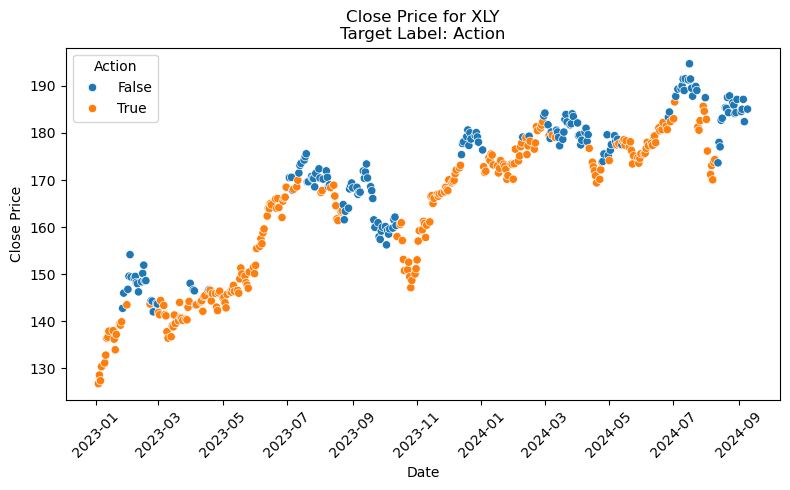

No data available for XLY


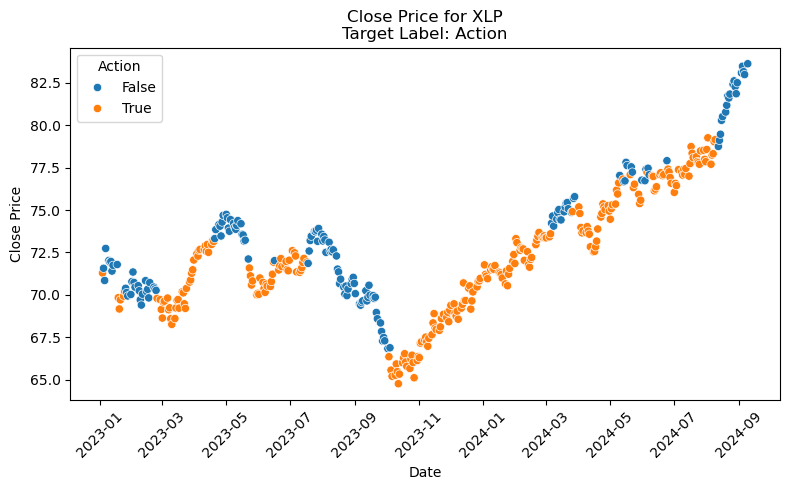

No data available for XLP


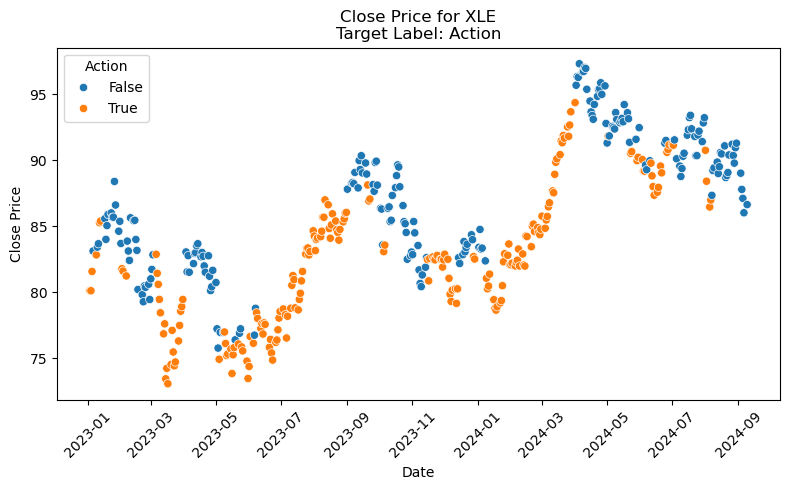

No data available for XLE


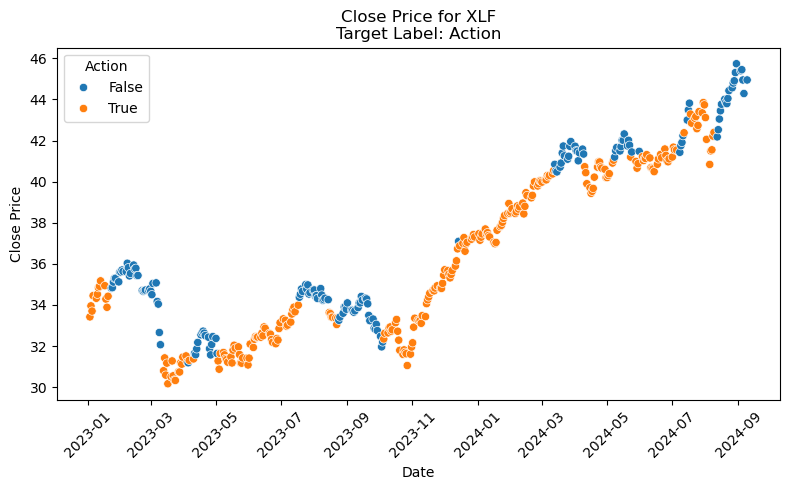

No data available for XLF


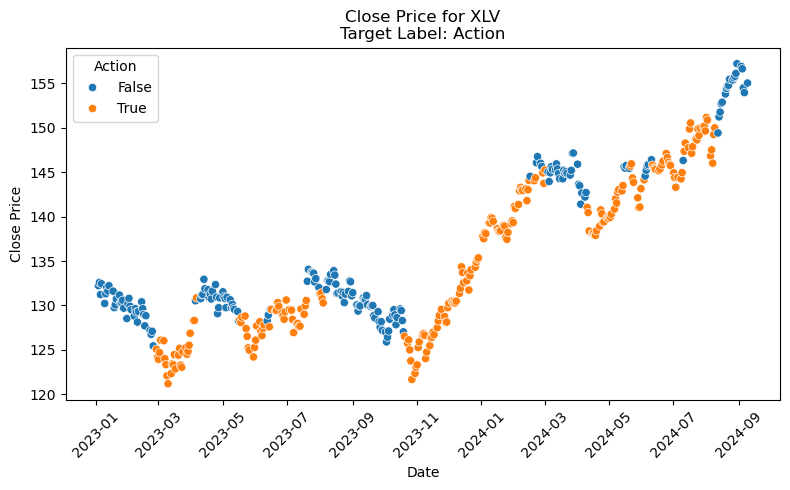

No data available for XLV


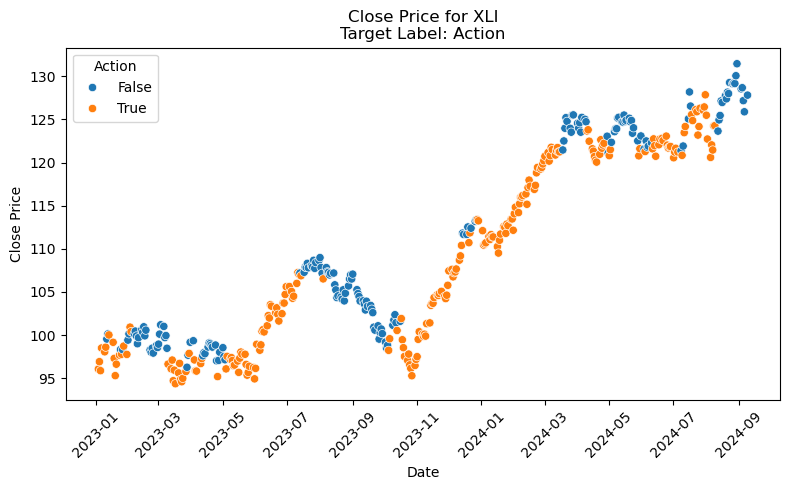

No data available for XLI


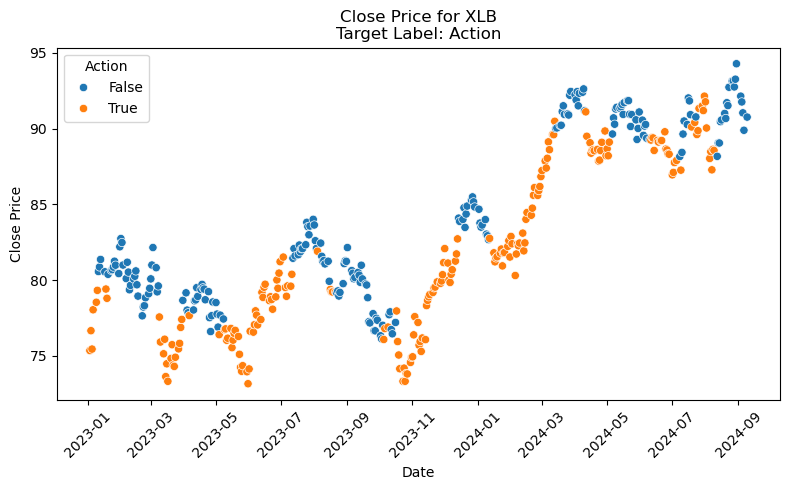

No data available for XLB


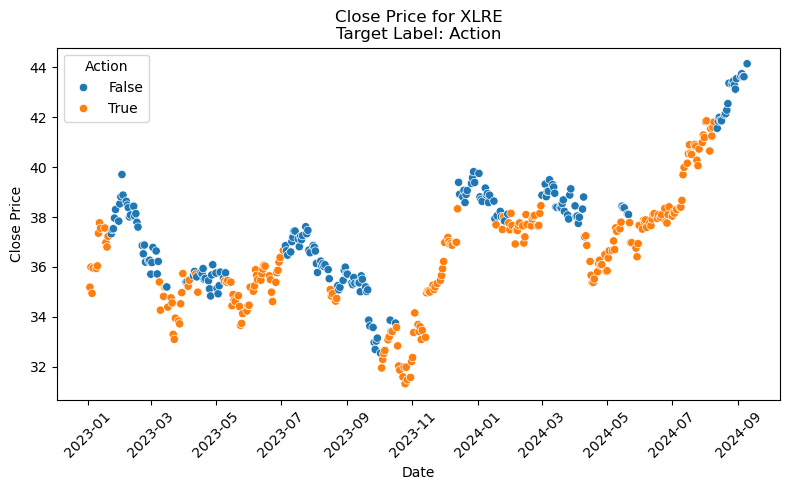

No data available for XLRE


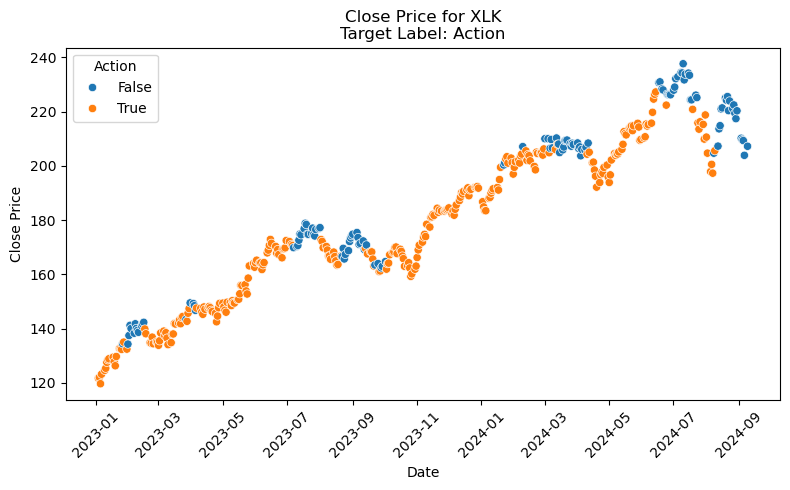

No data available for XLK


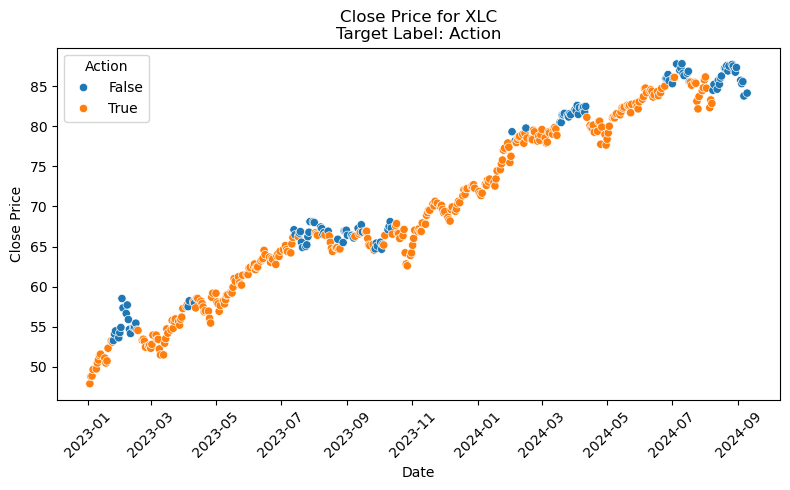

No data available for XLC


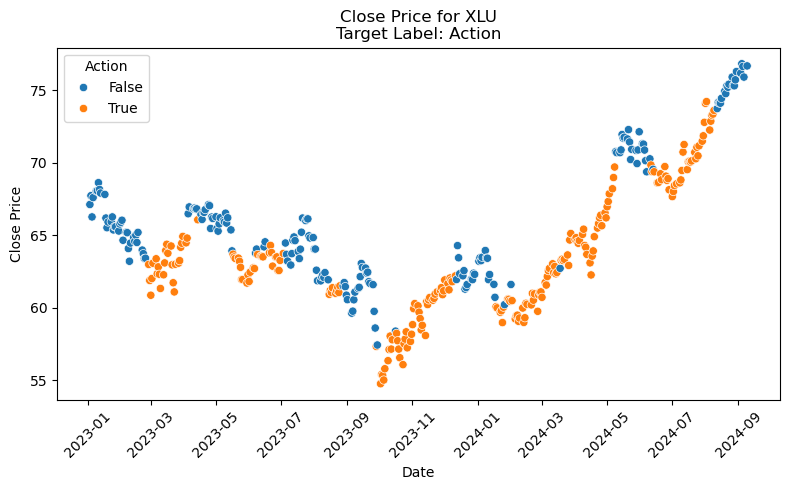

No data available for XLU


In [1206]:


def plot_hue_column(df,column='Action',plot_one=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')
    
    # Now plot for each ticker
    for ticker in sector_stocks.keys():
        data = df[df['Ticker'] == ticker]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break
        else:
            print(f"No data available for {ticker}")
testing_period=df_voo[df_voo['Year']>2022]
plot_hue_column(testing_period,column='Action')

In [1207]:
len(df_voo)

35714

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2810090000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


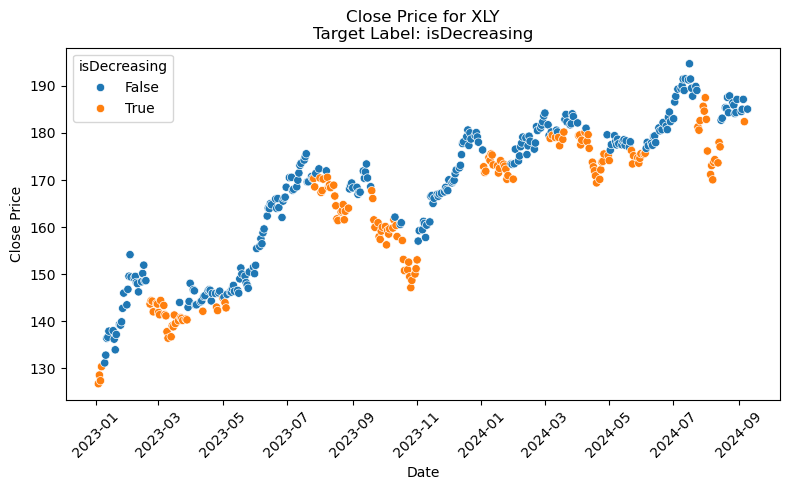

No data available for XLY


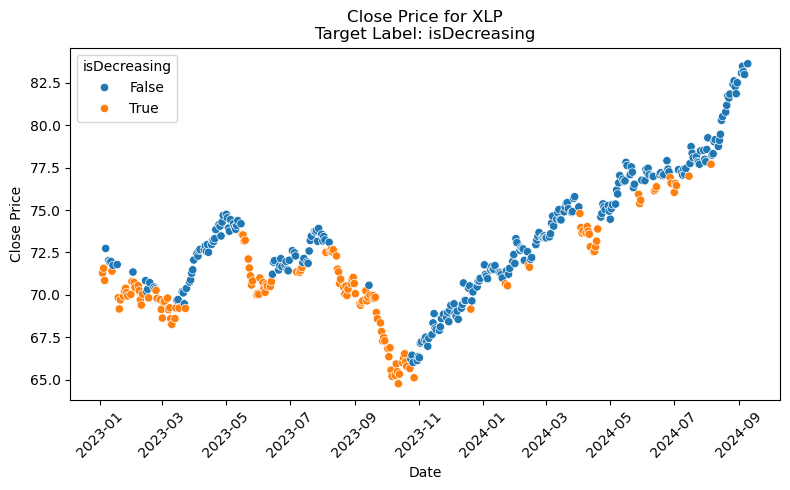

No data available for XLP


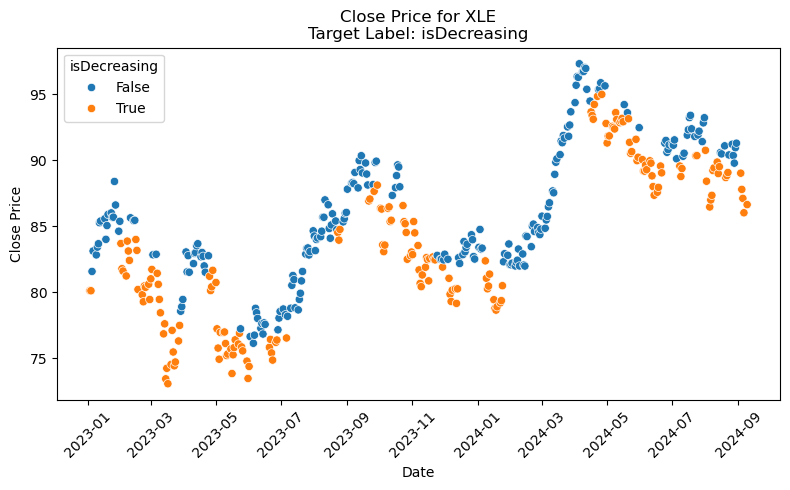

No data available for XLE


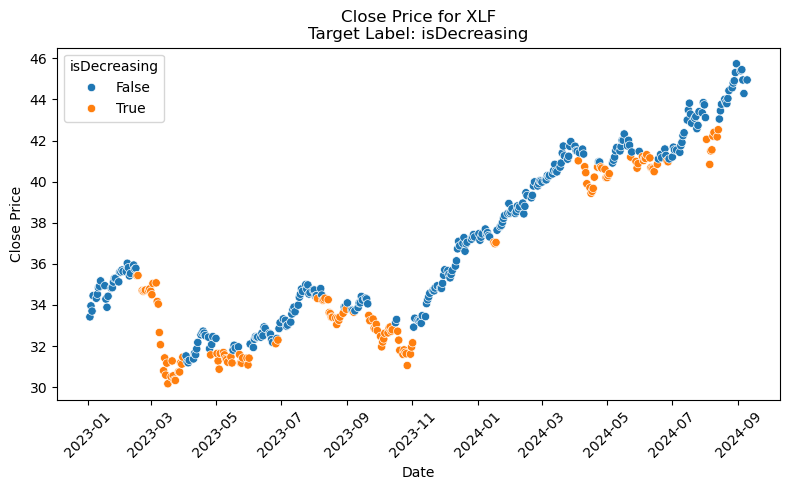

No data available for XLF


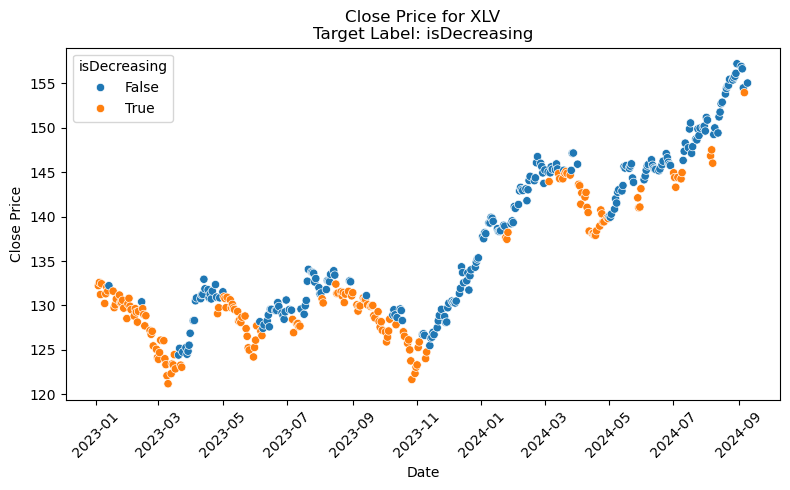

No data available for XLV


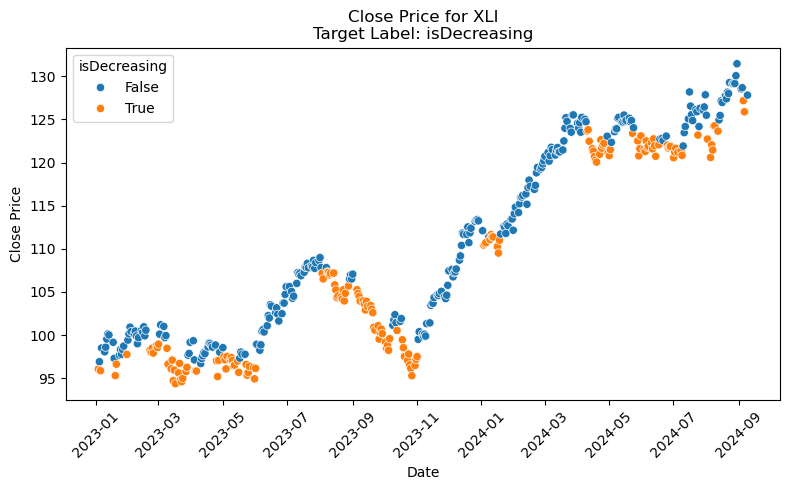

No data available for XLI


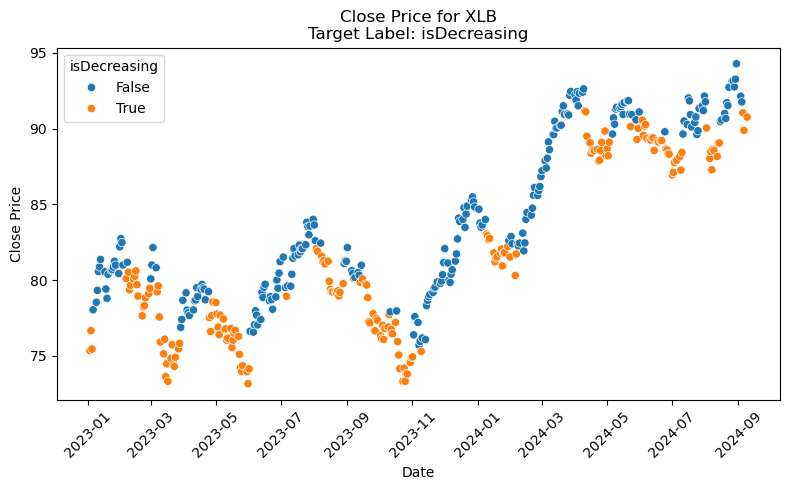

No data available for XLB


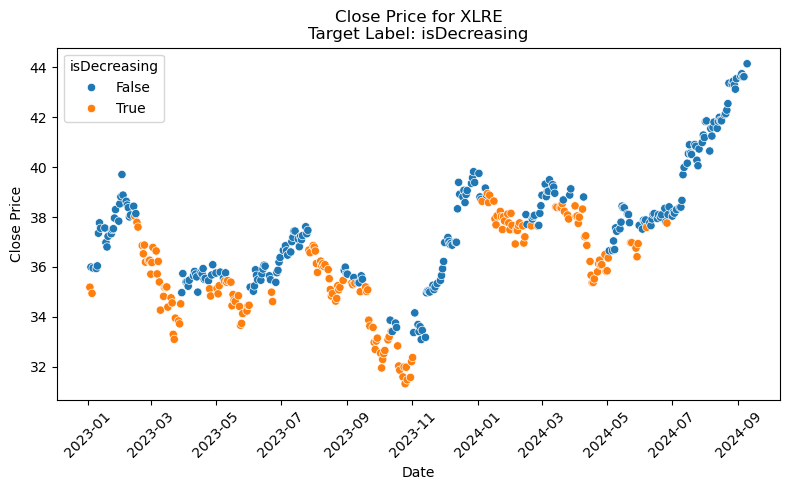

No data available for XLRE


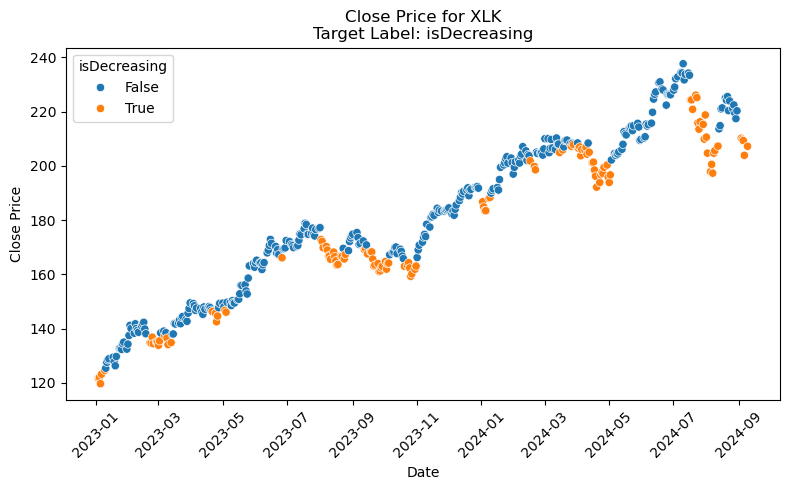

No data available for XLK


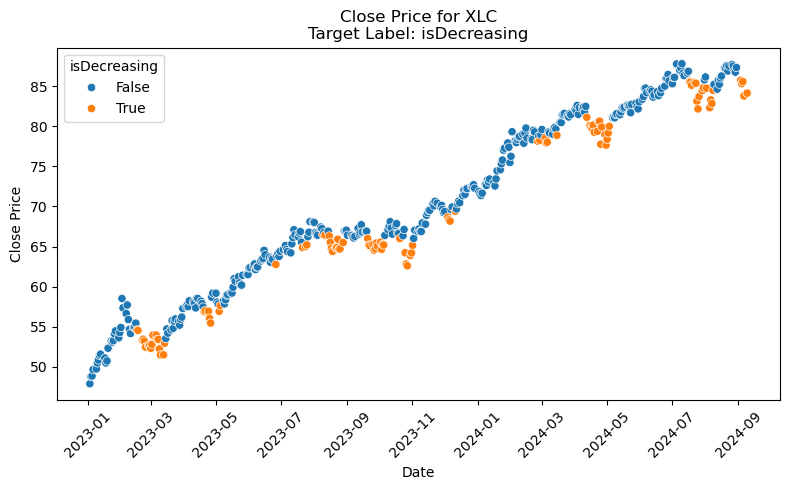

No data available for XLC


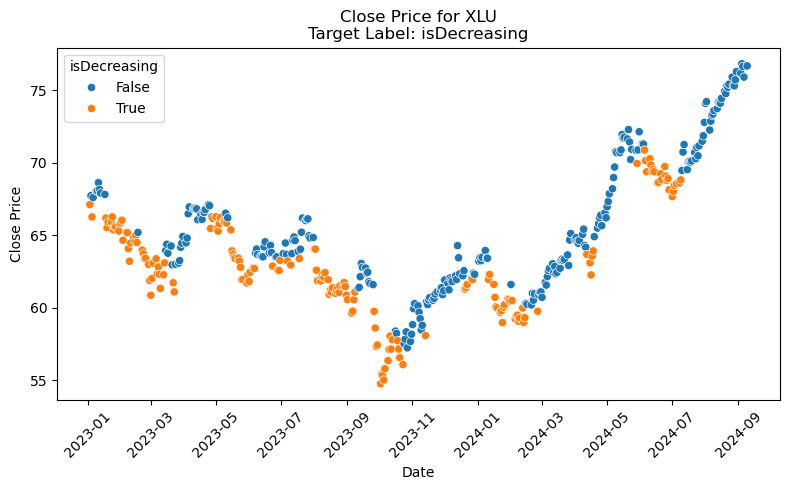

No data available for XLU


In [1208]:
plot_hue_column(testing_period,column='isDecreasing')

# Is Local Max
**The Is_Local_Max variable indicates if the closing price is a local max based on the previous 20 days.  Its lags can be used as a feature which could be another indicator of increasing decreasing behavior, or potentially the end of increasing behavior.**

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2810090000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


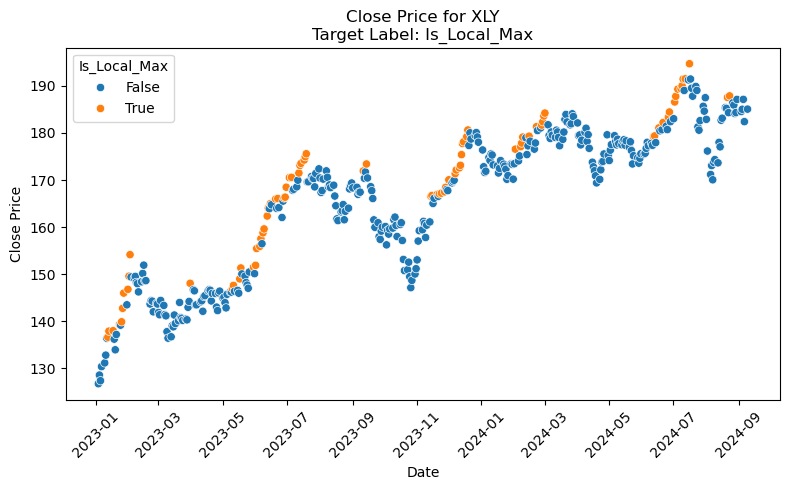

No data available for XLY


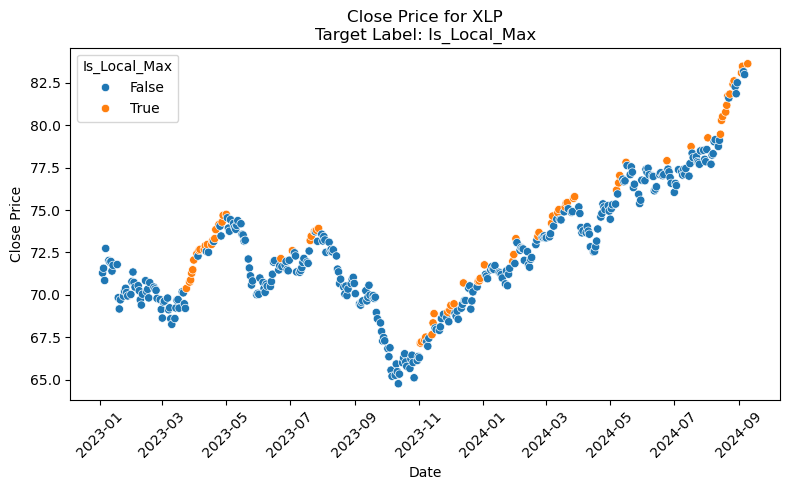

No data available for XLP


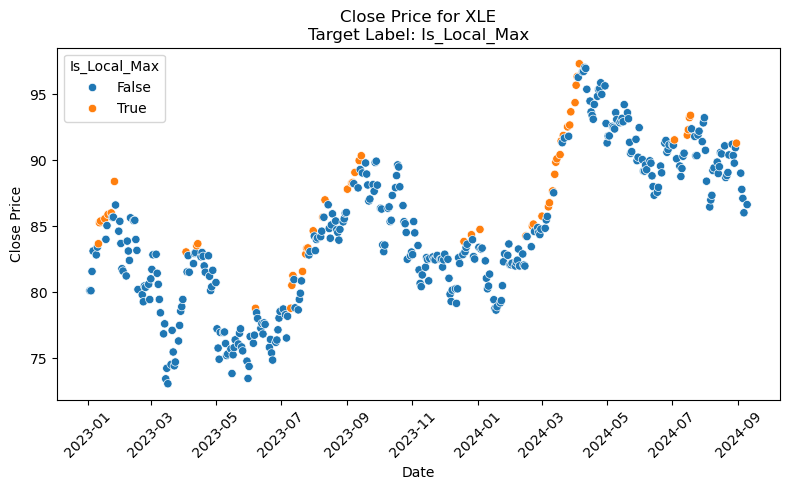

No data available for XLE


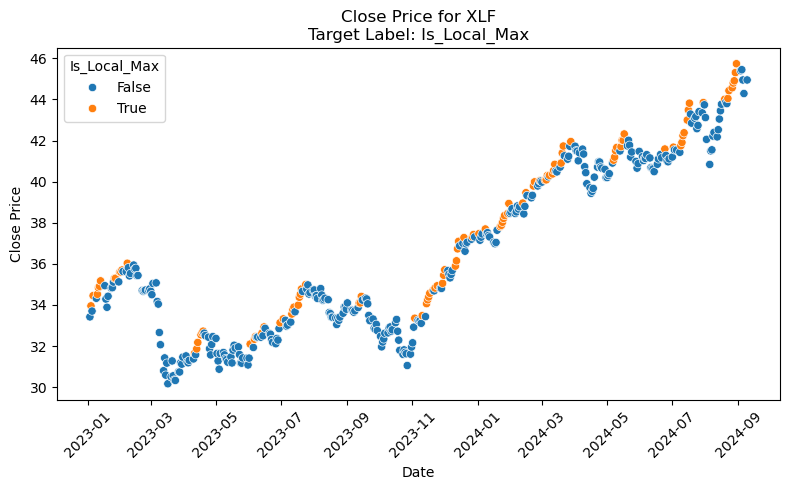

No data available for XLF


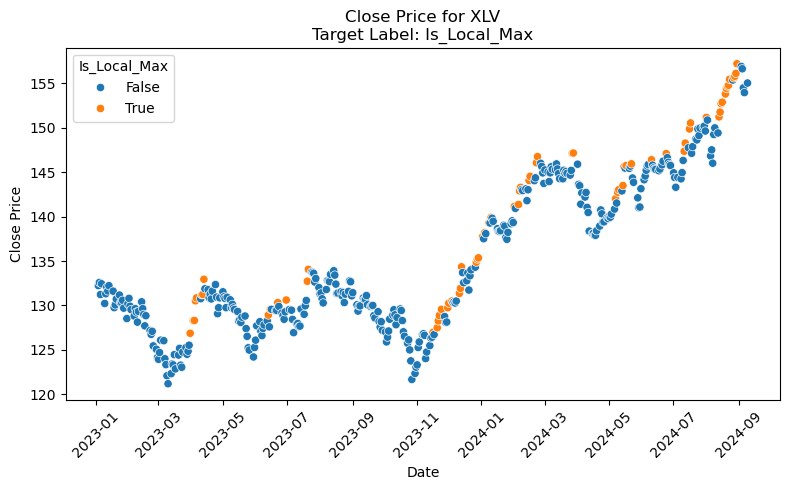

No data available for XLV


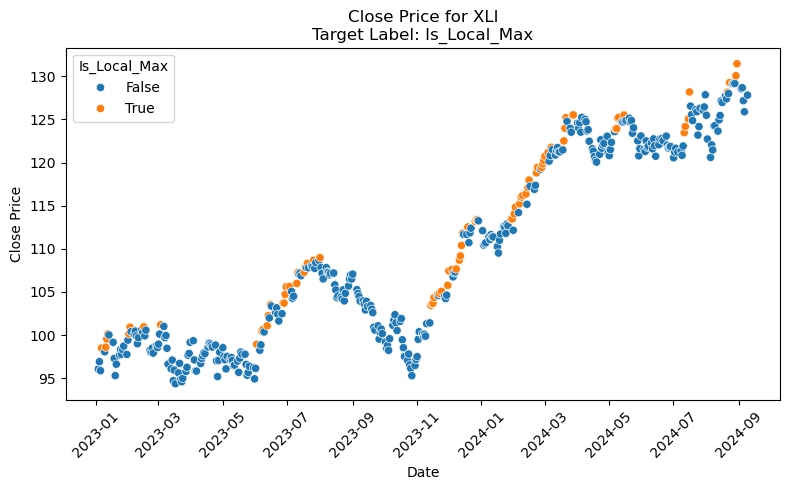

No data available for XLI


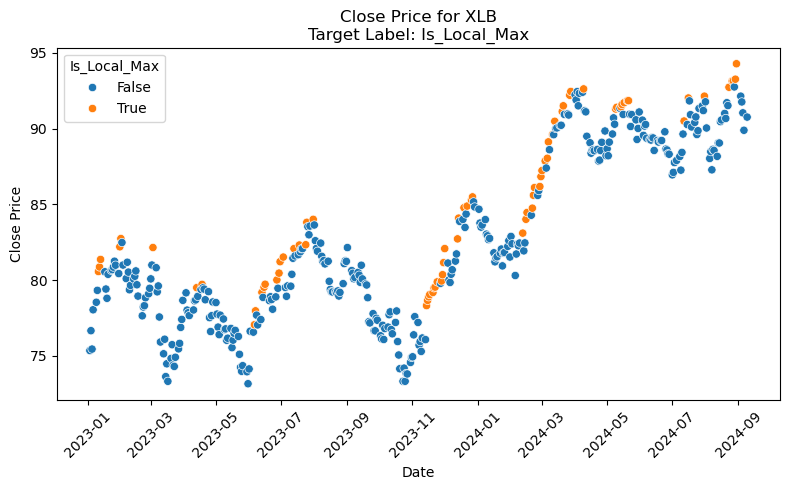

No data available for XLB


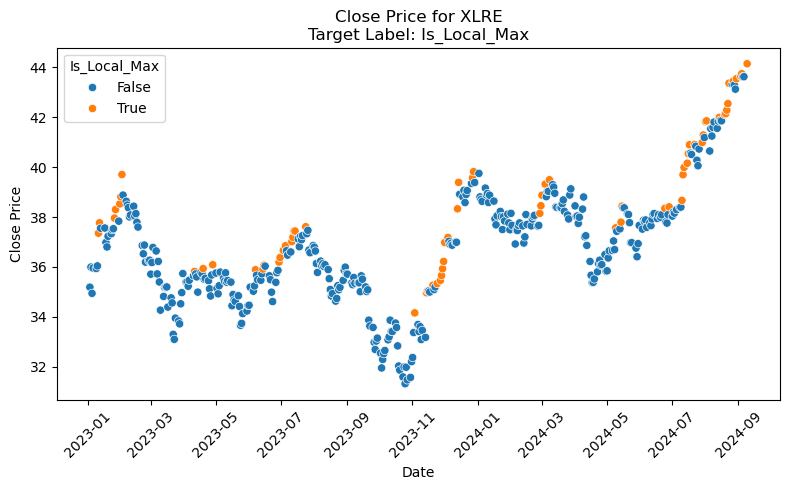

No data available for XLRE


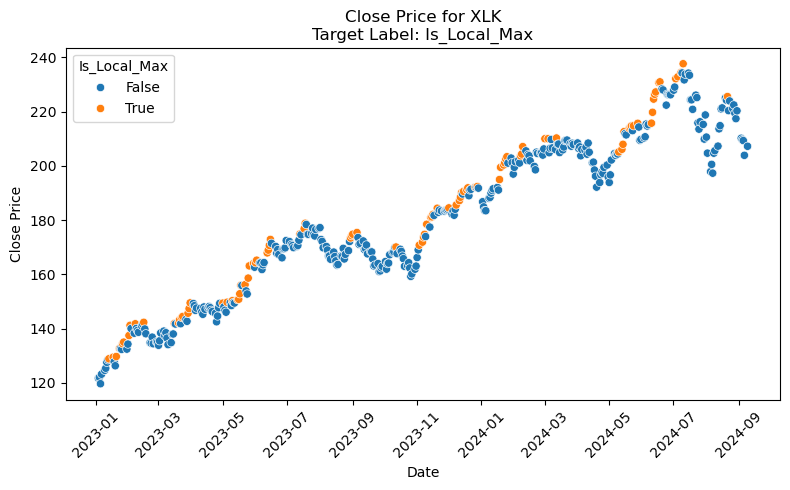

No data available for XLK


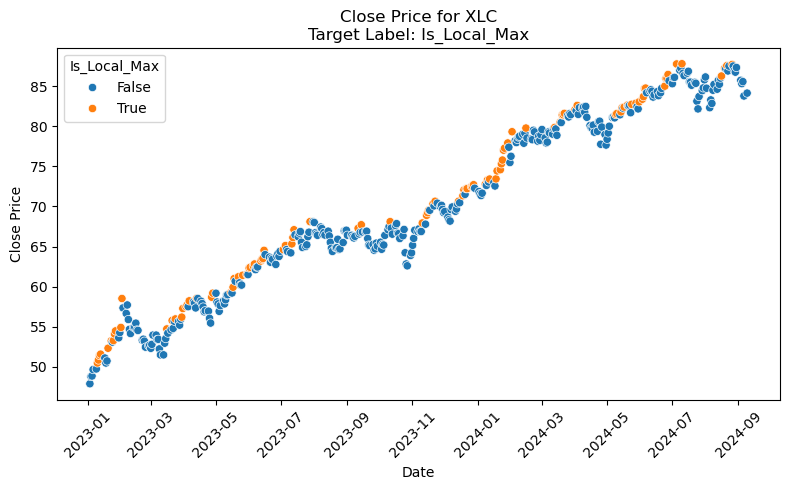

No data available for XLC


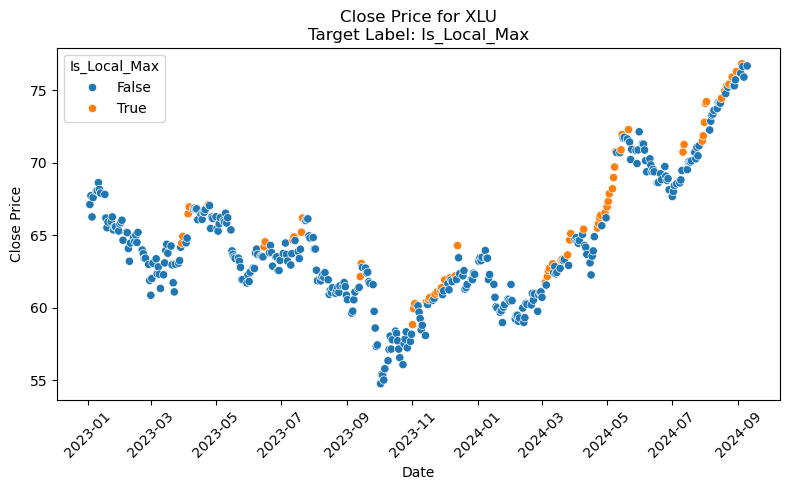

No data available for XLU


In [1210]:
plot_hue_column(testing_period, column='Is_Local_Max')

# Both increasing and Action
**Another possibility could be to use the combination of isDecreasing and Action as a target label**

In [1212]:
testing_period['test_label1']=(~testing_period['isDecreasing'])&(testing_period['Action'])
df_voo[['isDecreasing','Action']].value_counts()

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/4034254909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_period['test_label1']=(~testing_period['isDecreasing'])&(testing_period['Action'])


isDecreasing  Action
False         True      13896
              False      8643
True          True       8470
              False      4705
Name: count, dtype: int64

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2810090000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


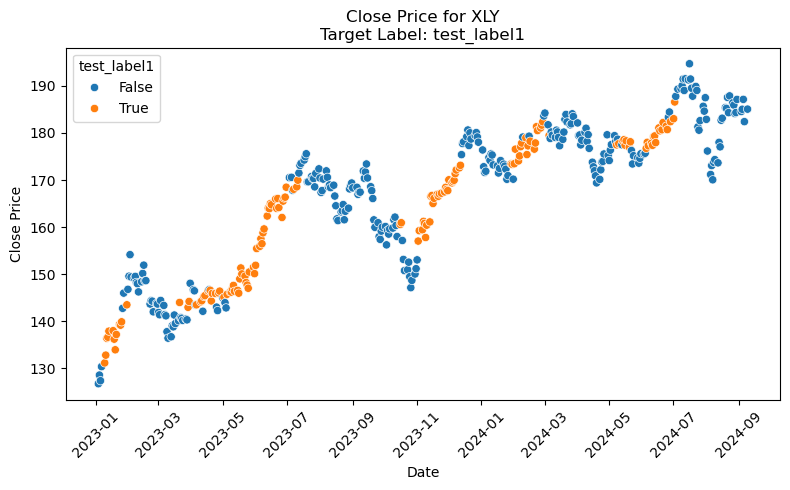

No data available for XLY


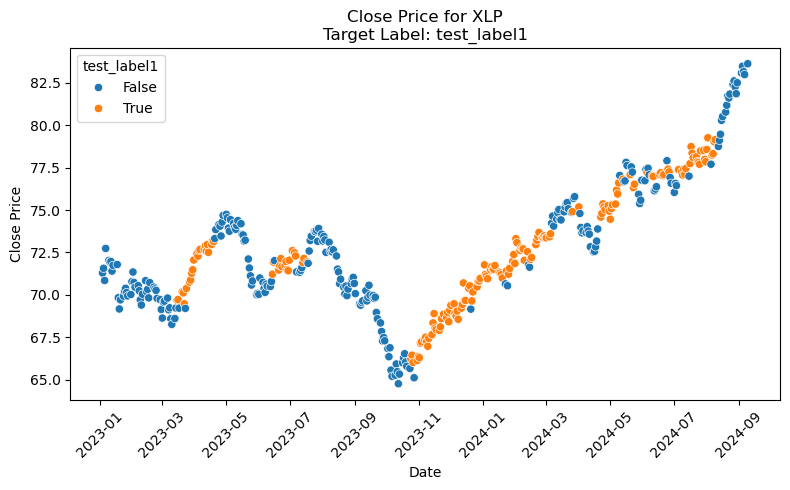

No data available for XLP


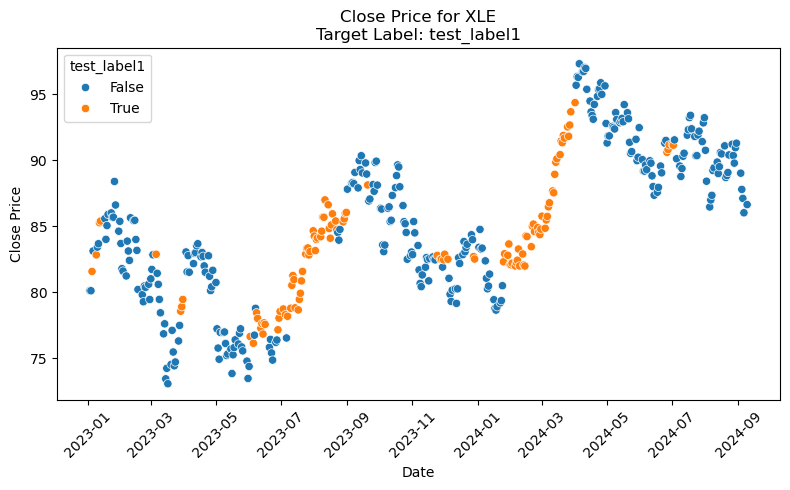

No data available for XLE


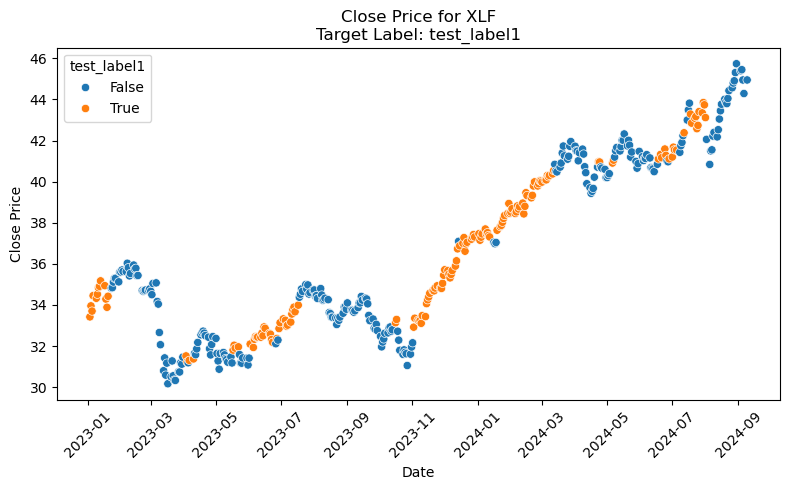

No data available for XLF


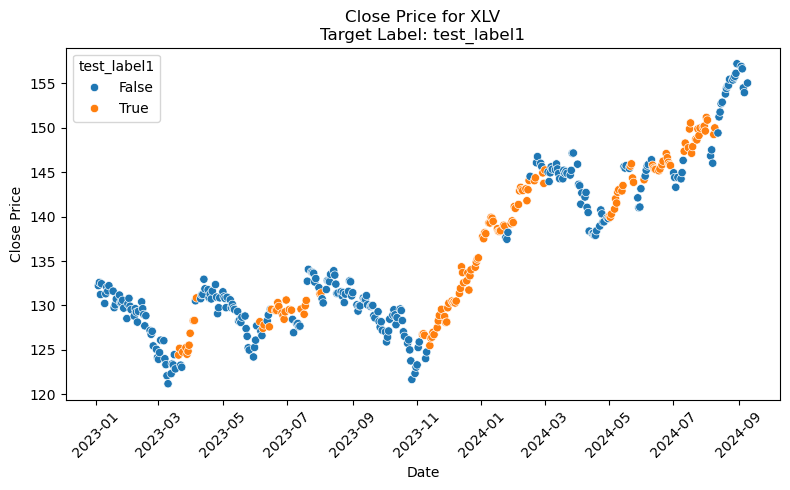

No data available for XLV


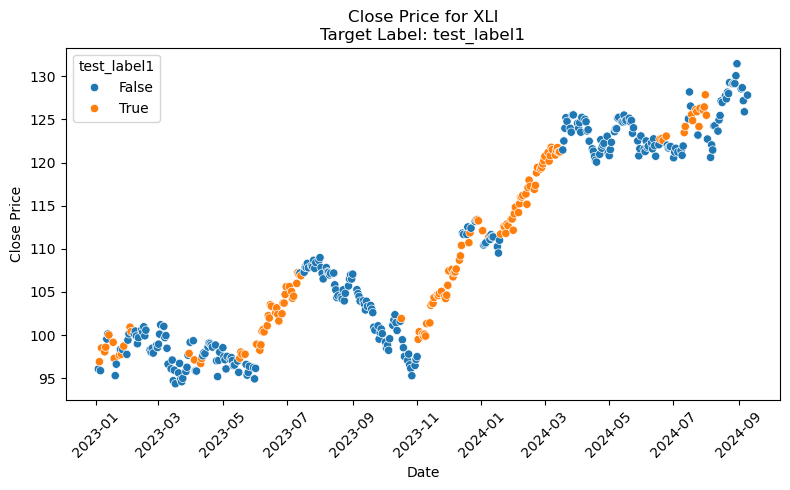

No data available for XLI


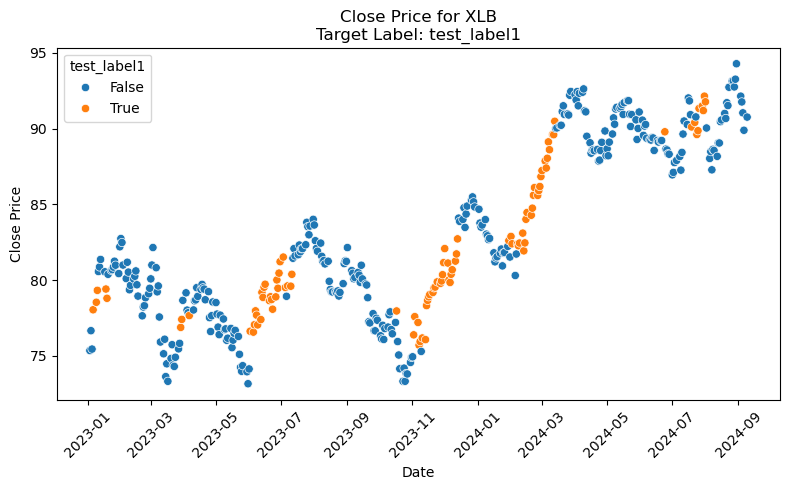

No data available for XLB


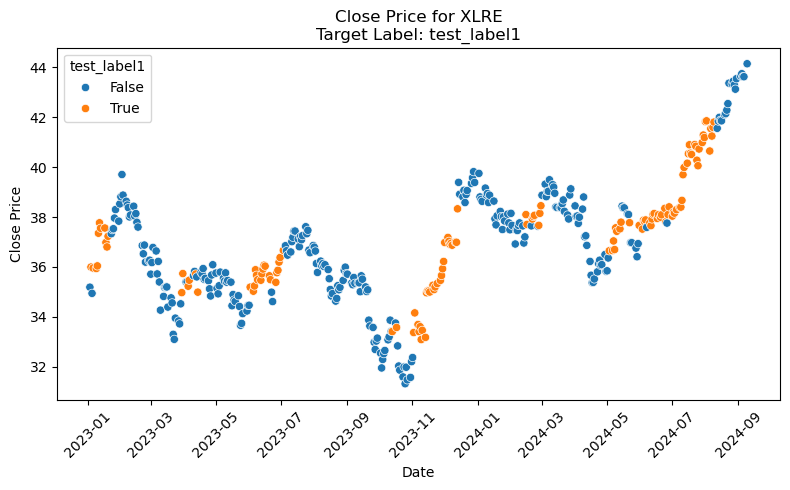

No data available for XLRE


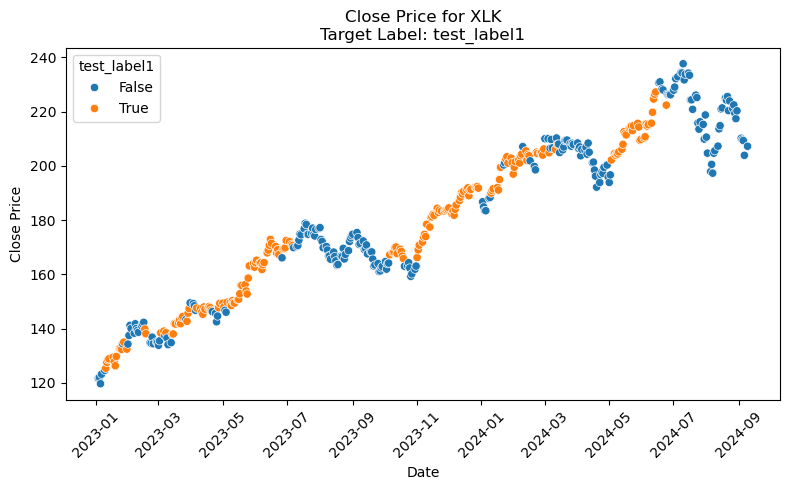

No data available for XLK


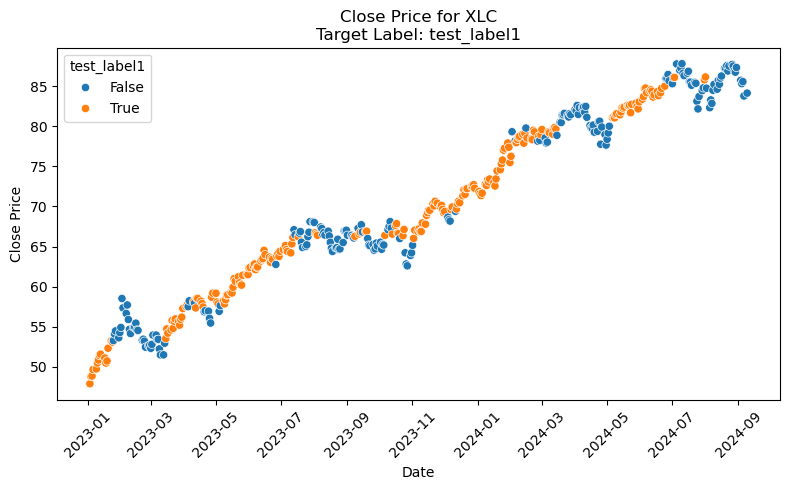

No data available for XLC


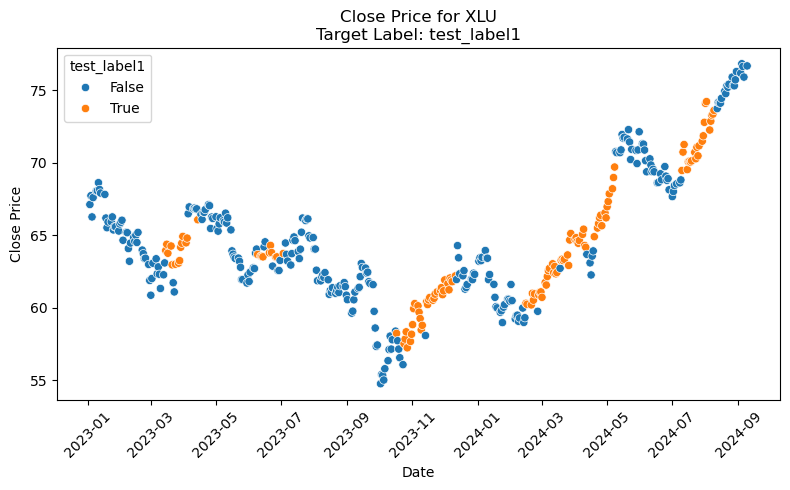

No data available for XLU


In [1213]:
plot_hue_column(testing_period, column='test_label1')

# Add The federal Funds rate and Unemployment rate to the data

In [1318]:
import pandas_datareader as pdr
from datetime import datetime


# Fetch the federal funds rate data
fed_funds_rate = pdr.get_data_fred('FEDFUNDS', start=start_date, end=end_date)


# Fetch the unemployment rate data
unemployment_rate = pdr.get_data_fred('UNRATE', start=start_date, end=end_date)

print(unemployment_rate.head())
print("\nMost recent unemployment rate:")
print(unemployment_rate.tail(1))

fed_funds_rate=fed_funds_rate.reset_index()
fed_funds_rate['DATE']=pd.to_datetime(fed_funds_rate['DATE'])
unemployment_rate=unemployment_rate.reset_index()
unemployment_rate['DATE']=pd.to_datetime(unemployment_rate['DATE'])
fed_funds_rate['Month']=fed_funds_rate['DATE'].dt.month
fed_funds_rate['Year']=fed_funds_rate['DATE'].dt.year
unemployment_rate['Month']=unemployment_rate['DATE'].dt.month
unemployment_rate['Year']=unemployment_rate['DATE'].dt.year
joined=pd.merge(df_voo,fed_funds_rate,on=['Month','Year'])
joined=pd.merge(joined,unemployment_rate,on=['Month','Year'])
try:
    joined=joined.drop(columns=['DATE_x','DATE_y'])
except:
    print('No duplicated date columns')

            UNRATE
DATE              
2012-01-01     8.3
2012-02-01     8.3
2012-03-01     8.2
2012-04-01     8.2
2012-05-01     8.2

Most recent unemployment rate:
            UNRATE
DATE              
2024-08-01     4.2


In [1216]:
df_voo.isnull().sum()

index                 32523
Date                      0
Open                      0
High                      0
Low                       0
                      ...  
isDecreasing_lag15      180
isDecreasing_lag16      192
isDecreasing_lag17      204
isDecreasing_lag18      216
isDecreasing_lag19      228
Length: 134, dtype: int64

# Add consumer price index to the data.

In [1319]:
# Fetch Consumer Price Index (CPI) data
cpi = pdr.get_data_fred('CPIAUCSL', start=start_date, end=end_date)

# Fetch Consumer Confidence Index data
#cci = pdr.get_data_fred('CSCICP03USM665S', start=start_date, end=end_date)

print("Consumer Price Index (CPI):")
print(cpi.tail())


cpi.columns = ['CPI']
cpi=cpi.reset_index()
cpi['Month']=cpi['DATE'].dt.month
cpi['Year']=cpi['DATE'].dt.year
joined=pd.merge(joined,cpi, on=['Month','Year'])

Consumer Price Index (CPI):
            CPIAUCSL
DATE                
2024-03-01   312.230
2024-04-01   313.207
2024-05-01   313.225
2024-06-01   313.049
2024-07-01   313.534


# Add lag columns for Unemployment rate, Federal Funds rate, and CPI.

In [1322]:
# Assuming 'joined' is your DataFrame with the necessary columns
cols = ['UNRATE', 'FEDFUNDS', 'CPI']
agg_d={col:'first' for col in cols}
grouped=joined.groupby(['Month','Year']).agg(agg_d).reset_index()
grouped=grouped.sort_values(by=['Year','Month'])
for col in cols:
    # Calculate the percent change and create a new column
    grouped[f'{col}_pct_change'] = grouped[col].pct_change() * 100  # Multiply by 100 to convert to percentage

# Create lagged features for the last 2 days of percent changes
for col in cols:
    for i in range(1, 3):  # Create lagged features for 1 and 2 days
        grouped[f'{col}_pct_change_lag{i}'] = grouped[f'{col}_pct_change'].shift(i)
joined=pd.merge(joined,grouped,on=['Month','Year'])

# A look at potential features

In [1324]:
features=[col for col in joined.columns if 'lag' in col]
features

['Close_pct_change_lag1',
 'Close_pct_change_lag2',
 'Close_pct_change_lag3',
 'Close_pct_change_lag4',
 'Close_pct_change_lag5',
 'Close_pct_change_lag6',
 'Close_pct_change_lag7',
 'Close_pct_change_lag8',
 'Close_pct_change_lag9',
 'Close_pct_change_lag10',
 'Close_pct_change_lag11',
 'Close_pct_change_lag12',
 'Close_pct_change_lag13',
 'Close_pct_change_lag14',
 'Close_pct_change_lag15',
 'Close_pct_change_lag16',
 'Close_pct_change_lag17',
 'Close_pct_change_lag18',
 'Close_pct_change_lag19',
 'Close_pct_change_lag20',
 'TTM_Weekly_change_lag1',
 'TTM_Weekly_change_lag2',
 'TTM_Weekly_change_lag3',
 'TTM_Weekly_change_lag4',
 'TTM_Weekly_change_lag5',
 'TTM_change_lag1',
 'TTM_raw_lag1',
 'TTM_change_lag2',
 'TTM_raw_lag2',
 'TTM_change_lag3',
 'TTM_raw_lag3',
 'TTM_change_lag4',
 'TTM_raw_lag4',
 'TTM_change_lag5',
 'TTM_raw_lag5',
 'TTM_change_lag6',
 'TTM_raw_lag6',
 'TTM_change_lag7',
 'TTM_raw_lag7',
 'TTM_change_lag8',
 'TTM_raw_lag8',
 'TTM_change_lag9',
 'TTM_raw_lag9',
 

# Drop rows where there are null values in the feature columns.  Null values are expected because of the lag columns.

In [1327]:
joined=joined.dropna(subset=features)
len(joined)

34706

# Ensure numeric data types

In [1312]:
from pandas.api.types import is_numeric_dtype
for col in joined[features].columns:
    if not is_numeric_dtype(joined[col]):
        print(col)

# Split data on Time. 70-30.

In [1329]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
ticker_dummies=True
if ticker_dummies:
    joined=pd.get_dummies(joined,columns=['Ticker'])

    features = [col for col in joined.columns if 'lag' in col] + ['Month']+[col for col in joined if 'Ticker' in col]
else:
    features = [col for col in joined.columns if 'lag' in col] + ['Month']

joined.sort_values(by='Date', inplace=True)
joined=joined.dropna(subset=features)
# Define the split point (e.g., 70% for training)
split_point = int(len(joined) * 0.7)

# Split the data into training and testing sets
train = joined.iloc[:split_point]
test = joined.iloc[split_point:]





# XgBoost Classifier using isDecreasing as the Target

In [1331]:
# Create the XGBoost classifier
X_train = train[features]
y_train = train['isDecreasing']
y_train2=train['Action']
X_test = test[features]
y_test = test['isDecreasing']
y_test2=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8795620437956204
Recall 0.8359059605794348
F1_score 0.8488063660477454
              precision    recall  f1-score   support

       False       0.89      0.91      0.90      6201
        True       0.86      0.84      0.85      4211

    accuracy                           0.88     10412
   macro avg       0.88      0.87      0.87     10412
weighted avg       0.88      0.88      0.88     10412



# Model does fairly well at predicting the increasing decreasing behavior of the next day.

In [1333]:
# Create the XGBoost classifier
features=[col for col in joined.columns if 'isDecreasing' in col]+[col for col in joined.columns if 'Ticker' in col]
features=[col for col in features if 'lag' in col]
X_train = train[features]
y_train = train['isDecreasing']
y_train2=train['Action']
X_test = test[features]
y_test = test['isDecreasing']
y_test2=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:18:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.8812908182865924
Recall 0.8458798385181667
F1_score 0.8521531100478469
              precision    recall  f1-score   support

       False       0.90      0.91      0.90      6201
        True       0.86      0.85      0.85      4211

    accuracy                           0.88     10412
   macro avg       0.88      0.88      0.88     10412
weighted avg       0.88      0.88      0.88     10412



**A model that just uses the lag columns of the isDecreasing variable is better.  In other words the increasing/decreasing behavior can be determined by whether or not the previous days were increasing/decreasing.  Adding additional features seems to hinder the models performance.**

# Use the Action Variable as the target.

In [1335]:
# Create the XGBoost classifier
from sklearn.metrics import precision_score
features=[col for col in joined.columns if 'lag' in col]+[col for col in joined.columns if 'Ticker' in col]
X_train = train[features]
y_train=train['Action']
X_test = test[features]
y_test=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print('Precision', precision_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:18:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5615635804840569
Recall 0.6847612818835841
F1_score 0.6472451897071324
Precision 0.6136263736263736
              precision    recall  f1-score   support

       False       0.46      0.39      0.42      4296
        True       0.61      0.68      0.65      6116

    accuracy                           0.56     10412
   macro avg       0.54      0.54      0.53     10412
weighted avg       0.55      0.56      0.55     10412



# Predicts invest days fairly well, but generates a lot of false positives.  Overall, probably not the most helpful model.

In [1337]:
from sklearn.metrics import confusion_matrix
import numpy as np

def print_custom_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Extract values from the confusion matrix
    tn, fp, fn, tp = cm.ravel()
    
    # Print the results
    print("False Negatives:", fn)
    print("True Negatives:", tn)
    print("\nAdditional Information:")
    print("True Positives:", tp)
    print("False Positives:", fp)
    
    # Calculate and print percentages
    total = tn + fp + fn + tp
    print("\nPercentages:")
    print(f"False Negatives: {fn/total:.2%}")
    print(f"True Negatives: {tn/total:.2%}")
    print(f"True Positives: {tp/total:.2%}")
    print(f"False Positives: {fp/total:.2%}")


print_custom_confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
negative_recall = tn / (tn + fp)
print(negative_recall)

False Negatives: 1928
True Negatives: 1659

Additional Information:
True Positives: 4188
False Positives: 2637

Percentages:
False Negatives: 18.52%
True Negatives: 15.93%
True Positives: 40.22%
False Positives: 25.33%
0.3861731843575419


**There is a higher percentage of False negatives than True negatives. The False negatives represent days that are profitable invest days but will be selected as non-invest days.  Also Noteworthy is that there is a higher percentage of False positives, compared to true negatives.  This all indicates that the model has trouble predicting the non_invest days.  The model does better with predicting the positive class. If the model makes a positive prediction there is around 60%(precision) chance that the day is actually a profitable invest day.  68%(recall) of the actual invest days were identified as invest days by the model.** 

# Visual look at the predicted invest days/non_invest days.

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/4011524818.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred']=y_pred
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/1014821011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


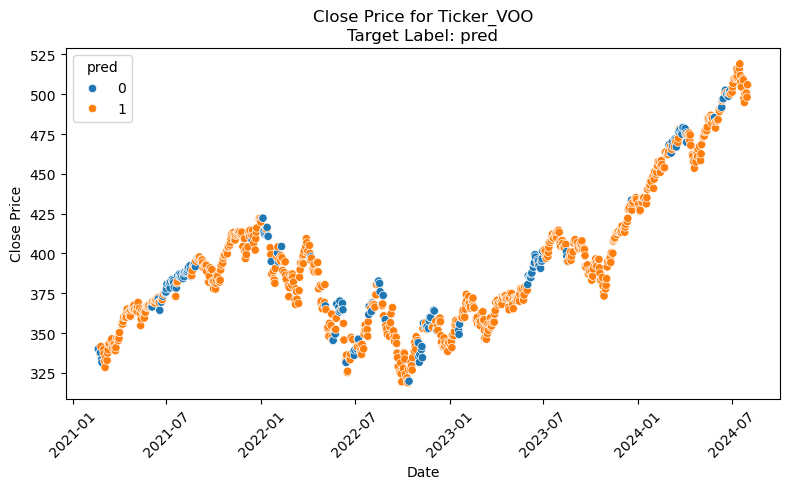

In [1339]:
test['pred']=y_pred
plot_hue_column2(test,column='pred',plot_one=True)
#test['Predicted_Action']=test['pred']
#test['Predicted_Action']=test.apply(lambda x: False if x['isDecreasing_lag1'] else x['Predicted_Action'], axis=1)
#test[['Date','isDecreasing']].to_csv('Action_Data.csv',index=False)

# Improve the model by removing features that negatively impact it.

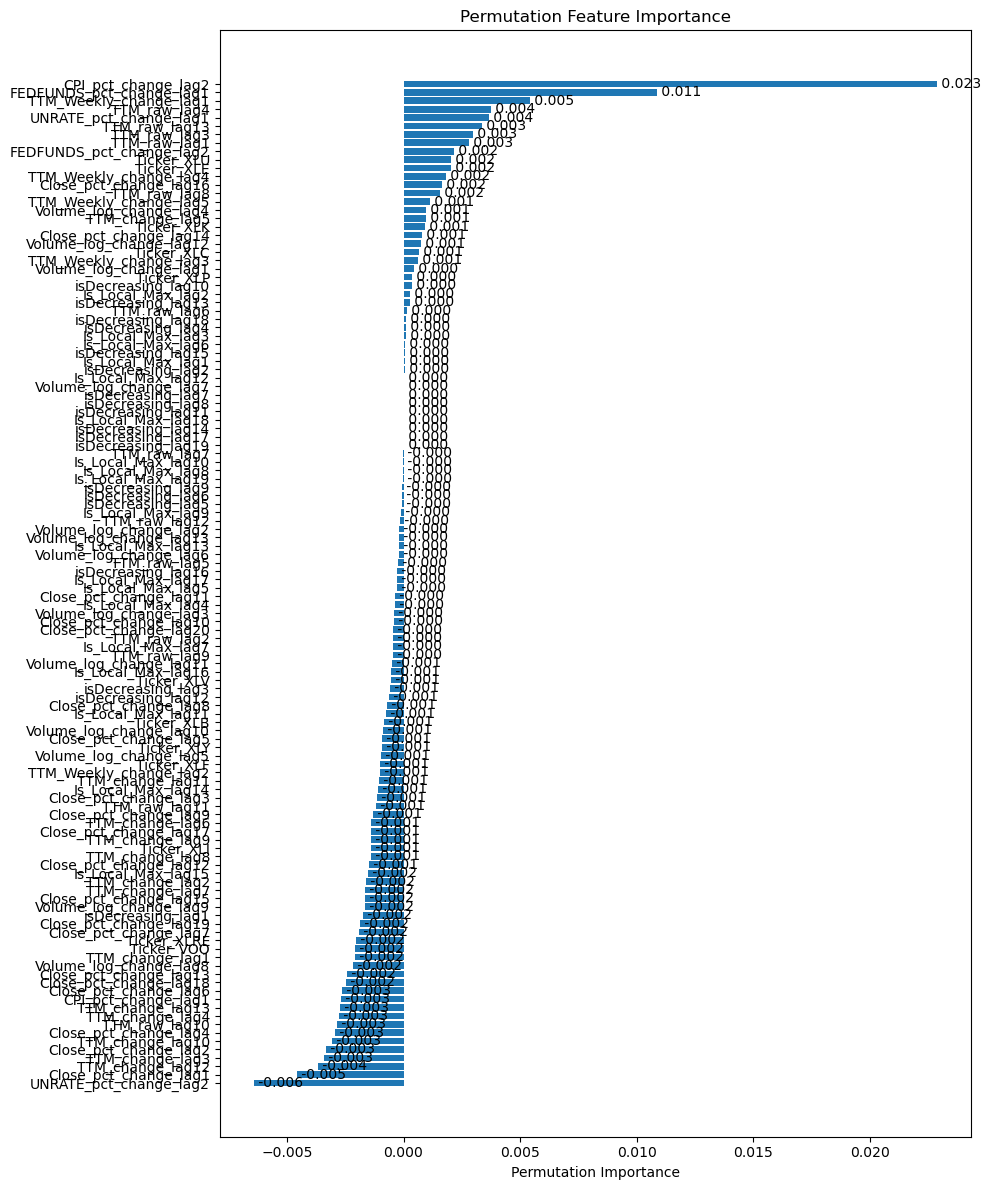

CPI_pct_change_lag2 : 0.023 +/- 0.003
FEDFUNDS_pct_change_lag1: 0.011 +/- 0.002
TTM_Weekly_change_lag1: 0.005 +/- 0.001
TTM_raw_lag4        : 0.004 +/- 0.001
UNRATE_pct_change_lag1: 0.004 +/- 0.003
TTM_raw_lag13       : 0.003 +/- 0.002
TTM_raw_lag3        : 0.003 +/- 0.001
TTM_raw_lag1        : 0.003 +/- 0.002
FEDFUNDS_pct_change_lag2: 0.002 +/- 0.002
Ticker_XLU          : 0.002 +/- 0.001
Ticker_XLE          : 0.002 +/- 0.001
TTM_Weekly_change_lag4: 0.002 +/- 0.002
Close_pct_change_lag16: 0.002 +/- 0.001
TTM_raw_lag8        : 0.002 +/- 0.001
TTM_Weekly_change_lag5: 0.001 +/- 0.002
Volume_log_change_lag4: 0.001 +/- 0.001
TTM_change_lag5     : 0.001 +/- 0.001
Ticker_XLK          : 0.001 +/- 0.001
Close_pct_change_lag14: 0.001 +/- 0.001
Volume_log_change_lag12: 0.001 +/- 0.001
Ticker_XLC          : 0.001 +/- 0.001
TTM_Weekly_change_lag3: 0.001 +/- 0.002
Volume_log_change_lag1: 0.000 +/- 0.001
Ticker_XLP          : 0.000 +/- 0.001
isDecreasing_lag10  : 0.000 +/- 0.000
Is_Local_Max_lag2   :

In [1341]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Assuming you have your model, X_train, and y_train already defined

# Perform permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort features by importance
sorted_idx = result.importances_mean.argsort()
sorted_features = X_train.columns[sorted_idx]

# Plot the permutation importance
plt.figure(figsize=(10, 12))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), sorted_features)
plt.xlabel("Permutation Importance")
plt.title("Permutation Feature Importance")

# Add value labels to the end of each bar
for i, v in enumerate(result.importances_mean[sorted_idx]):
    plt.text(v, i, f" {v:.3f}", va='center')

plt.tight_layout()
plt.show()

# Print the feature importances
keep_columns=[]
for i in sorted_idx[::-1]:
    print(f"{X_train.columns[i]:<20}: {result.importances_mean[i]:.3f} +/- {result.importances_std[i]:.3f}")
    if result.importances_mean[i]>0:
        keep_columns.append(X_train.columns[i])


In [1343]:

X_train = train[keep_columns]
y_train=train['Action']
X_test = test[keep_columns]
y_test=test['Action']
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=42)
#model=LogisticRegression(max_iter=1200)
#model=RandomForestClassifier(n_estimators=400, min_samples_split=5, min_samples_leaf=7,max_features='log2')
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print('Recall', recall_score(y_test,y_pred))
print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.5730887437572032
Recall 0.7074885546108568
F1_score 0.6606611191694023
              precision    recall  f1-score   support

       False       0.48      0.38      0.42      4296
        True       0.62      0.71      0.66      6116

    accuracy                           0.57     10412
   macro avg       0.55      0.54      0.54     10412
weighted avg       0.56      0.57      0.56     10412



**Removing the features improves the model accuracy, recall and f1_score**

In [1345]:
print_custom_confusion_matrix(y_test, y_pred)
print_custom_confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
negative_recall = tn / (tn + fp)
print('Specificity (True Negative Rate): ',negative_recall)

False Negatives: 1789
True Negatives: 1640

Additional Information:
True Positives: 4327
False Positives: 2656

Percentages:
False Negatives: 17.18%
True Negatives: 15.75%
True Positives: 41.56%
False Positives: 25.51%
False Negatives: 1789
True Negatives: 1640

Additional Information:
True Positives: 4327
False Positives: 2656

Percentages:
False Negatives: 17.18%
True Negatives: 15.75%
True Positives: 41.56%
False Positives: 25.51%
Specificity (True Negative Rate):  0.3817504655493482


In [1347]:
def plot_hue_column2(df,column='Action',plot_one=False):
    # Convert all dates to UTC, then remove timezone information
    df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)
    
    # Sort the dataframe
    df = df.sort_values(by='Date')
    
    # Now plot for each ticker
    ticker_columns=[col for col in df.columns if 'Ticker' in col]
    for ticker in ticker_columns:
        data = df[df[ticker]]
        if not data.empty:  # Check if there's data for this ticker
            fig, ax = plt.subplots(figsize=(8, 5))
            sns.scatterplot(x='Date', y='Close', data=data, hue=column, ax=ax)
            ax.set_title(f'Close Price for {ticker}\nTarget Label: {column}')
            ax.set_xlabel('Date')
            ax.set_ylabel('Close Price')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        if plot_one:
            break
        else:
            print(f"No data available for {ticker}")

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/250441007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred']=y_pred
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/1014821011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


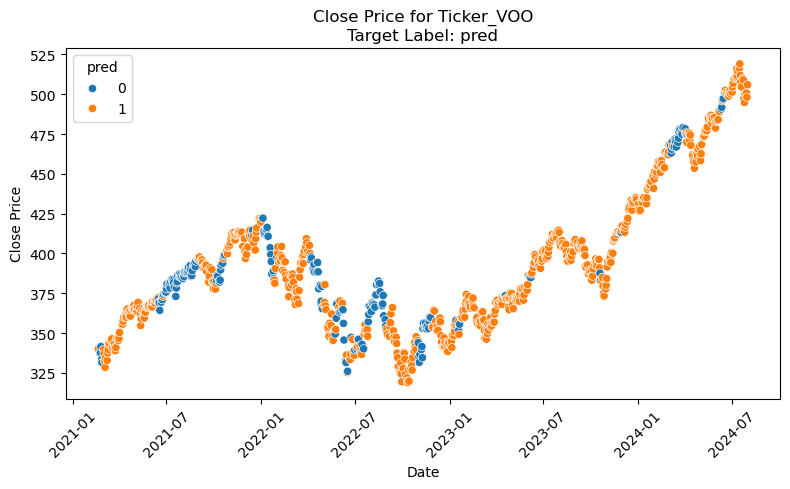

No data available for Ticker_VOO


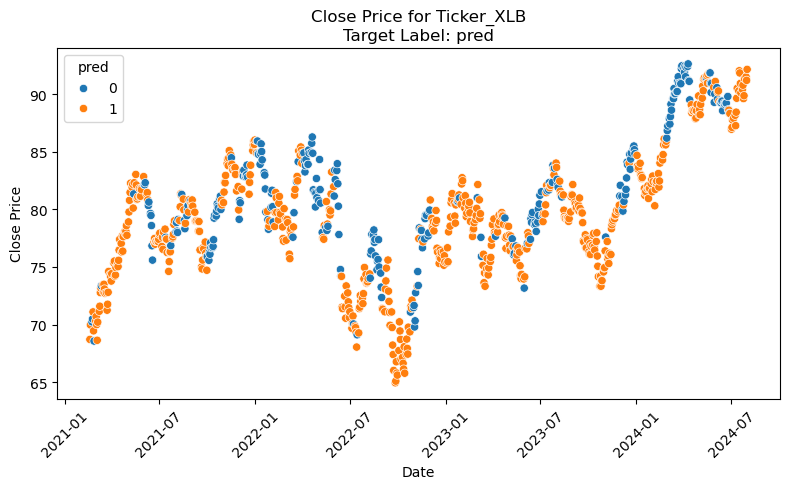

No data available for Ticker_XLB


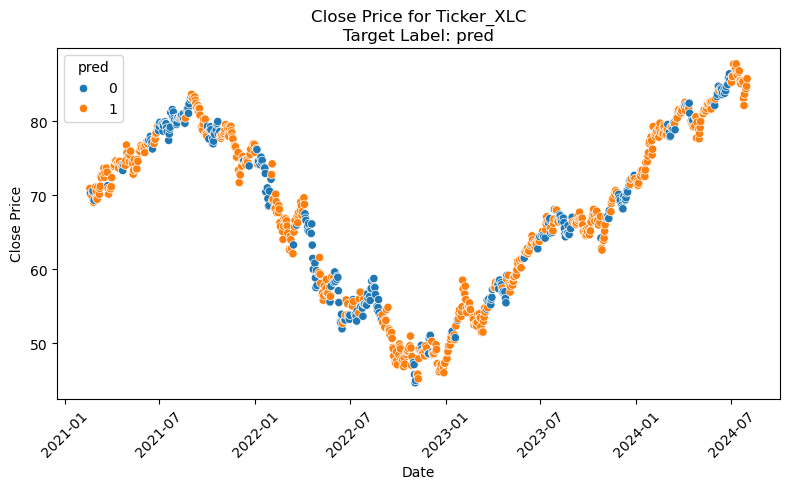

No data available for Ticker_XLC


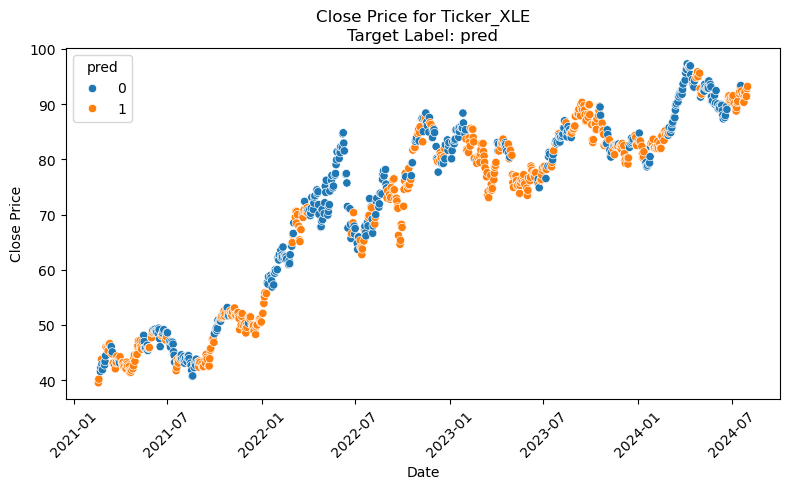

No data available for Ticker_XLE


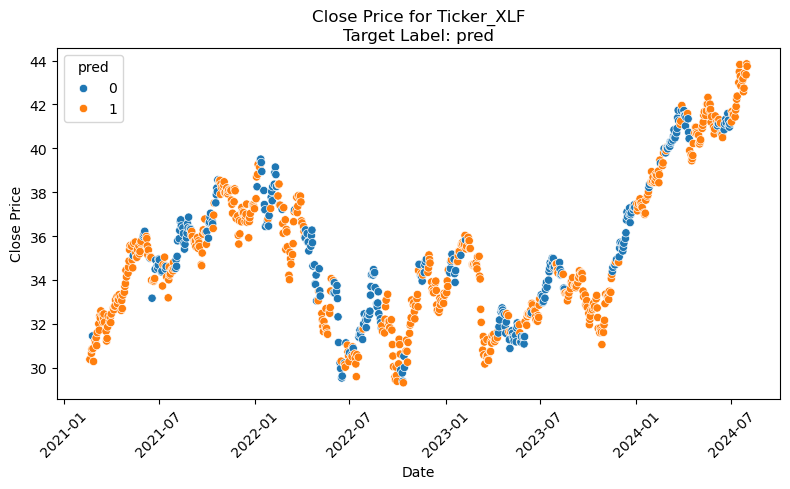

No data available for Ticker_XLF


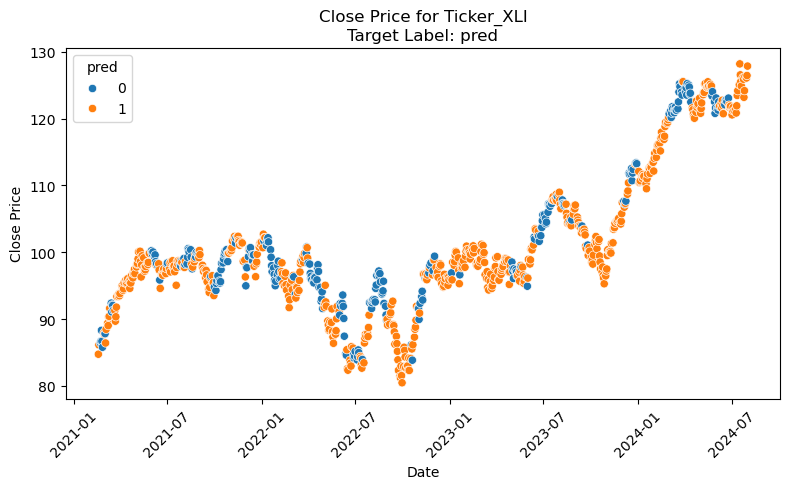

No data available for Ticker_XLI


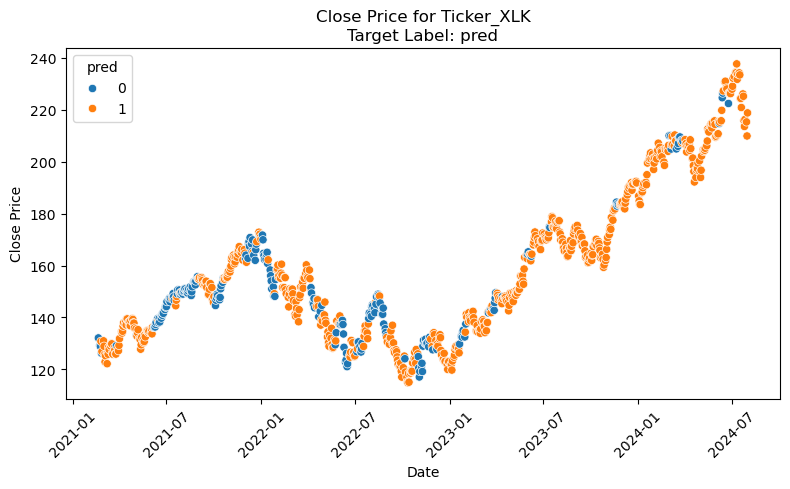

No data available for Ticker_XLK


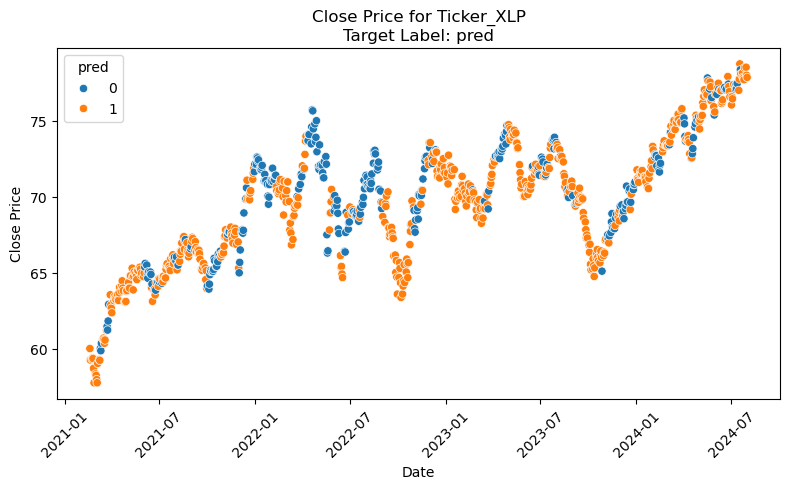

No data available for Ticker_XLP


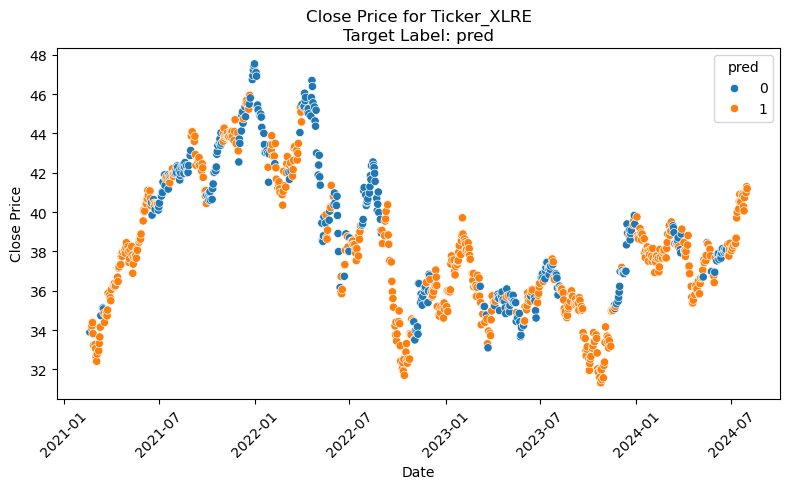

No data available for Ticker_XLRE


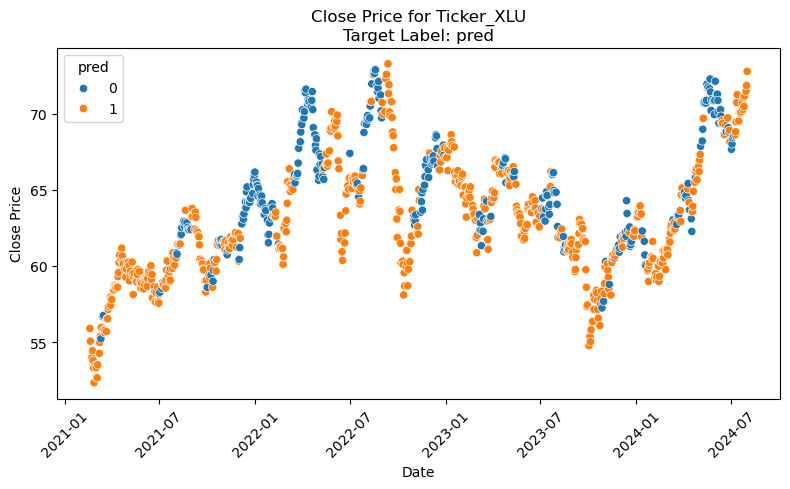

No data available for Ticker_XLU


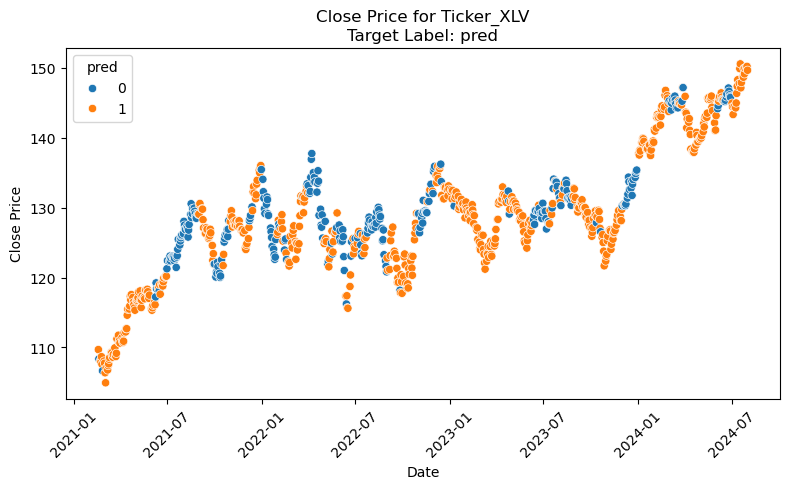

No data available for Ticker_XLV


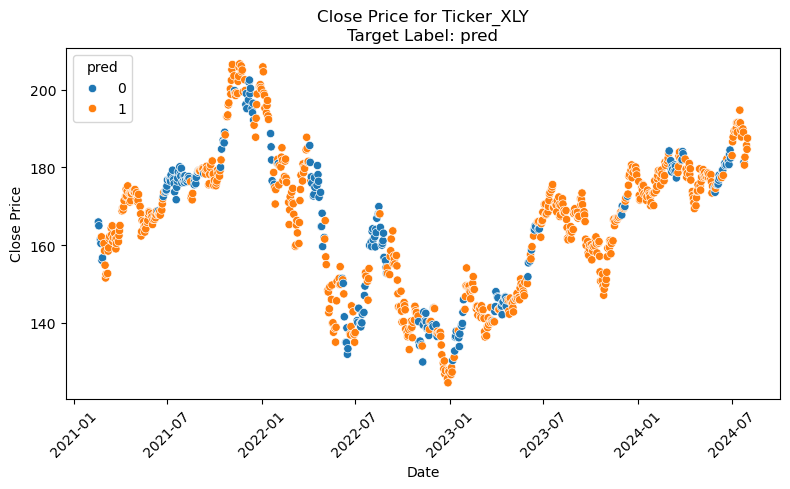

No data available for Ticker_XLY


In [1349]:
test['pred']=y_pred
plot_hue_column2(test,column='pred')

# Look at the actual percentage changes of the predicted invest days compared to the predicted non_invest days.

In [1351]:
print('Average Percentage Change for Invest Days')
print(f"{test[test['pred']==1]['Future_pct_change'].mean()*100}%")

Average Percentage Change for Invest Days
1.3812727519291452%


In [1353]:
print('Average Percentage Change for Non Invest Days')
print(f"{test[test['pred']!=1]['Future_pct_change'].mean()*100}%")


Average Percentage Change for Non Invest Days
-0.022901351221988338%


**It is encouraging that the predicted invest days have a positive average percent change and non_invest days have a negative average percent change**

# Adjust (reduce) the probability Threshold to elimate the occurence of false negatives.

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2892277658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pred_prob']=y_pred_proba[:,1] #Probability of invest day


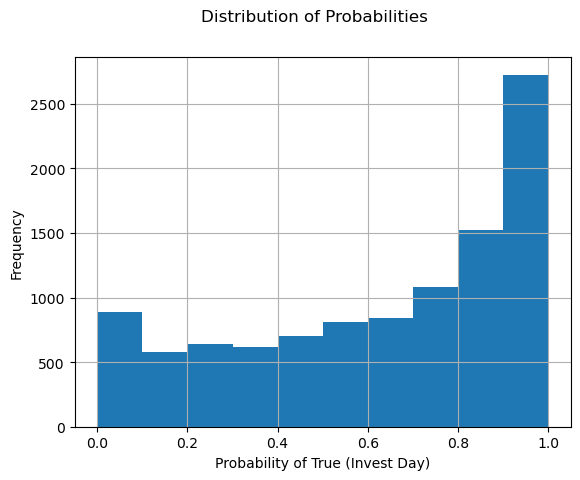

In [1355]:
y_pred_proba = model.predict_proba(X_test)
test['pred_prob']=y_pred_proba[:,1] #Probability of invest day
fig, ax=plt.subplots()
test['pred_prob'].hist(ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Distribution of Probabilities')
plt.show()

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/574227327.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['False_negative']=(test['Action'])&(~test['pred'])
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/574227327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['True_negative']=(~test['Action'])&(~test['pred'])


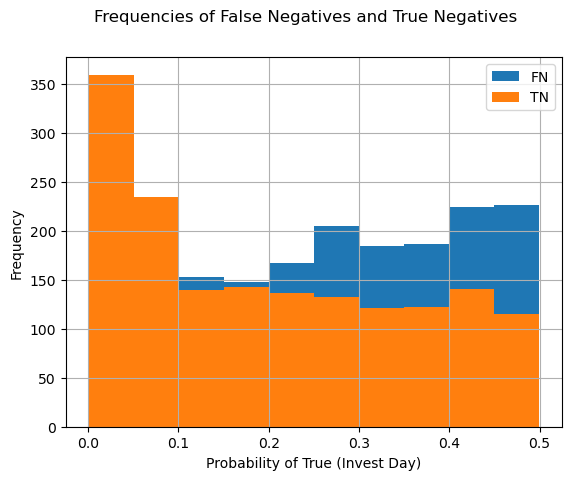

In [1357]:
test['False_negative']=(test['Action'])&(~test['pred'])
fig,ax=plt.subplots()
test[test['False_negative']]['pred_prob'].hist(ax=ax,label='FN')
test['True_negative']=(~test['Action'])&(~test['pred'])
test[test['True_negative']]['pred_prob'].hist(label='TN',ax=ax)
ax.set_xlabel('Probability of True (Invest Day)')
ax.set_ylabel('Frequency')
fig.suptitle('Frequencies of False Negatives and True Negatives')
plt.legend()

**Graph shows that in the range 0.2 to 0.5 there are more False negatives than True Negatives, This indicates that using a threshold of 0.2 instead of 0.5 will improve model accuracy and possibly the overall net gain.  Doing this Just means that if the model is going to predict a non_invest day, it is going to do it with more confidence.  However, predicting an invest day requires less confidence.**

In [1359]:
test['Predicted_Action2']=test['pred_prob']>=0.2
non_invest_avg_change=test[~test['Predicted_Action2']]['Future_pct_change'].mean()
invest_avg_change=test[test['Predicted_Action2']]['Future_pct_change'].mean()
print('*'*15,'Results After Adjustment','*'*15)
print()
print('Average Percentage Change for Non Invest Days', f"{non_invest_avg_change*100}%")
print('Average Percentage Change for Invest Days', f"{invest_avg_change*100}%")

*************** Results After Adjustment ***************

Average Percentage Change for Non Invest Days -1.5414190446661702%
Average Percentage Change for Invest Days 1.3236020923929046%


/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/584475407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Action2']=test['pred_prob']>=0.2


**The result is a much larger negative percentage in the non_invest day data.  Presumably, we have isolated the days that are associated with significant negative change, at the expense of including the days with less significant negative change into the positive category, Below shows the number of industry/date combinations that are predicted as invest and non invest. The final model scores are also shown below.**

In [1361]:
test['Predicted_Action2'].value_counts()

Predicted_Action2
True     8941
False    1471
Name: count, dtype: int64

In [1363]:
print('Accuracy',accuracy_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('Recall',recall_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print('F1_Score',f1_score(test['Action'].astype(int),test['Predicted_Action2'].astype(int)))
print_custom_confusion_matrix(test['Action'].astype(int),test['Predicted_Action2'].astype(int))

Accuracy 0.6140030733768729
Recall 0.9023871811641596
F1_Score 0.7330809590223816
False Negatives: 597
True Negatives: 874

Additional Information:
True Positives: 5519
False Positives: 3422

Percentages:
False Negatives: 5.73%
True Negatives: 8.39%
True Positives: 53.01%
False Positives: 32.87%


**We see that now the model identifies 90% of the actual profitable investment days as such.  The True negatives now represent a higher percentage than the False Negatives.  The True positive percent has increased by a higher percent than the False positive percent.  The overall affect is a model with a higher overall accuracy and f1_score**

# Model Explainer

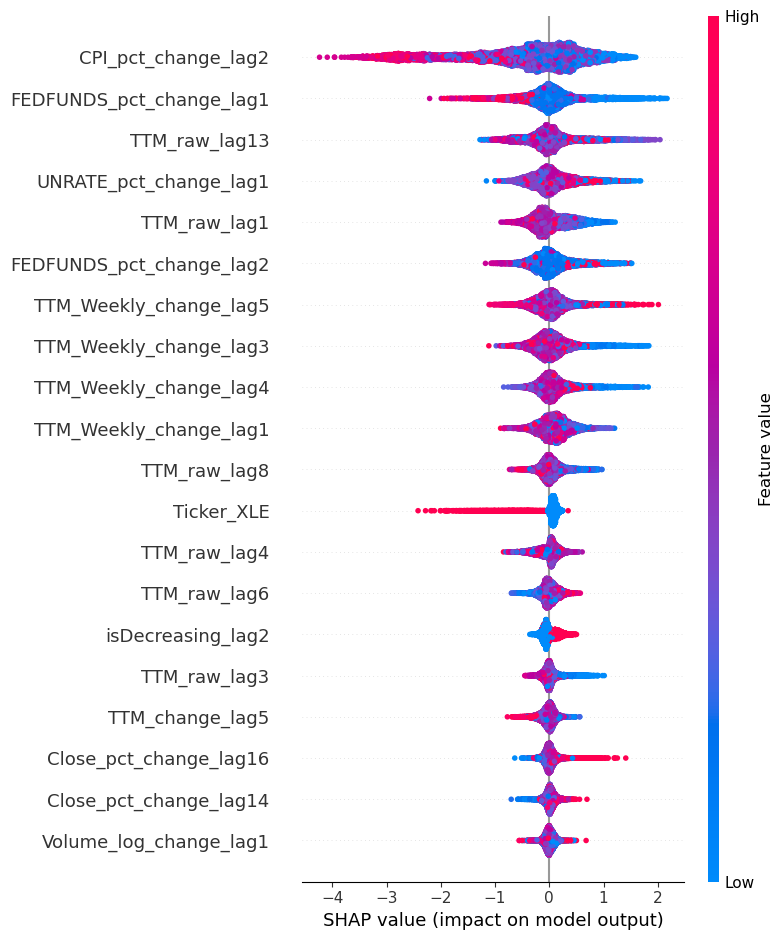

In [1286]:
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split

# Calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.initjs()  # Initialize JavaScript visualization in Jupyter Notebook

# Summary plot
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction
shap.plots.force(shap_values[0])  # Change the index for different predictions


# The data is written to csv where it is tested with investment simulation.

In [1294]:
test['Predicted_Action']=test['pred']
test['Predicted_Action2']=test['Predicted_Action2'].astype(int)
data=test[test['Year']>=2022]
#data['Predicted_Action']=data['Predicted_Action2'].astype(int)
data['Date']=data['Date'].dt.date
data[['Date','Predicted_Action','Predicted_Action2']+[col for col in test.columns if 'Ticker' in col]].to_csv('Action_Data.csv',index=False)

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/915067278.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Action']=test['pred']
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/915067278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted_Action2']=test['Predicted_Action2'].astype(int)
/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/915067278.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [1298]:
for col in test.columns:
    print(col)
test['Ticker']

index
Date
Open
High
Low
Close
Volume
Dividends
Stock Splits
Capital Gains
Is_Local_Max
Week
Year
Weekly_TTM
TTM
metric
donch
sma
MA
isDecreasing
Future_Close20
Future_Close19
Future_Close21
Action
Month
Future_pct_change
Performance_Label
Close_pct_change
Close_pct_change_lag1
Close_pct_change_lag2
Close_pct_change_lag3
Close_pct_change_lag4
Close_pct_change_lag5
Close_pct_change_lag6
Close_pct_change_lag7
Close_pct_change_lag8
Close_pct_change_lag9
Close_pct_change_lag10
Close_pct_change_lag11
Close_pct_change_lag12
Close_pct_change_lag13
Close_pct_change_lag14
Close_pct_change_lag15
Close_pct_change_lag16
Close_pct_change_lag17
Close_pct_change_lag18
Close_pct_change_lag19
Close_pct_change_lag20
TTM_Weekly_change
TTM_Weekly_change_lag1
TTM_Weekly_change_lag2
TTM_Weekly_change_lag3
TTM_Weekly_change_lag4
TTM_Weekly_change_lag5
TTM_change
TTM_change_lag1
TTM_raw_lag1
TTM_change_lag2
TTM_raw_lag2
TTM_change_lag3
TTM_raw_lag3
TTM_change_lag4
TTM_raw_lag4
TTM_change_lag5
TTM_raw_lag5
TTM

KeyError: 'Ticker'

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/1014821011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


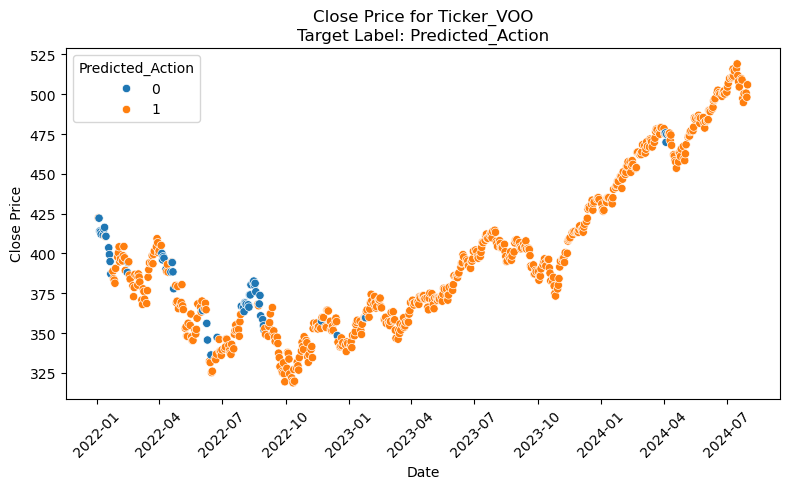

No data available for Ticker_VOO


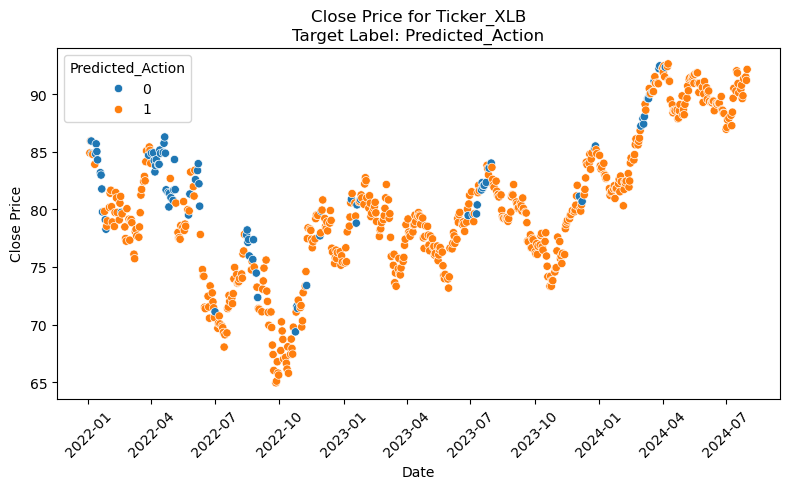

No data available for Ticker_XLB


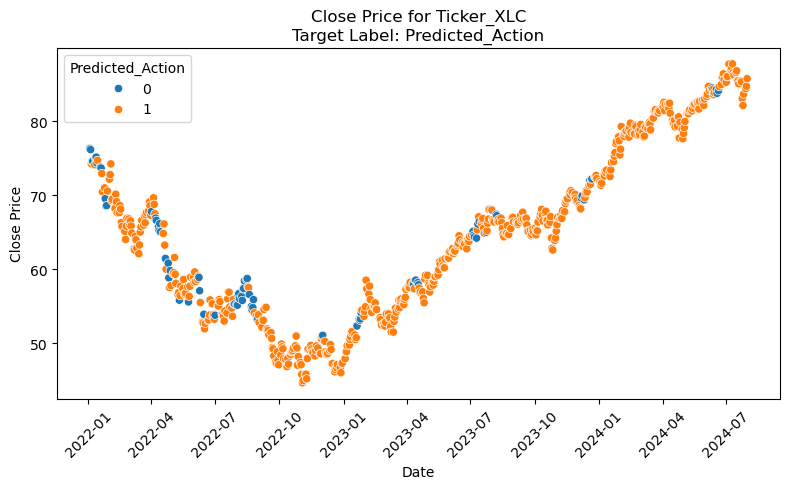

No data available for Ticker_XLC


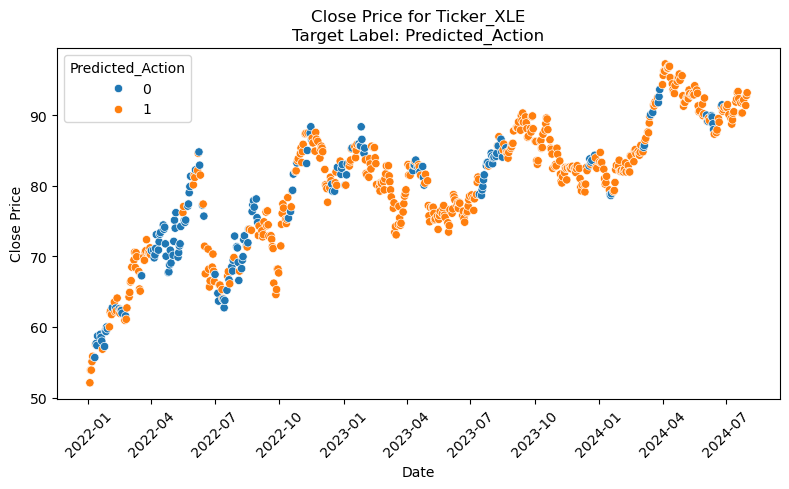

No data available for Ticker_XLE


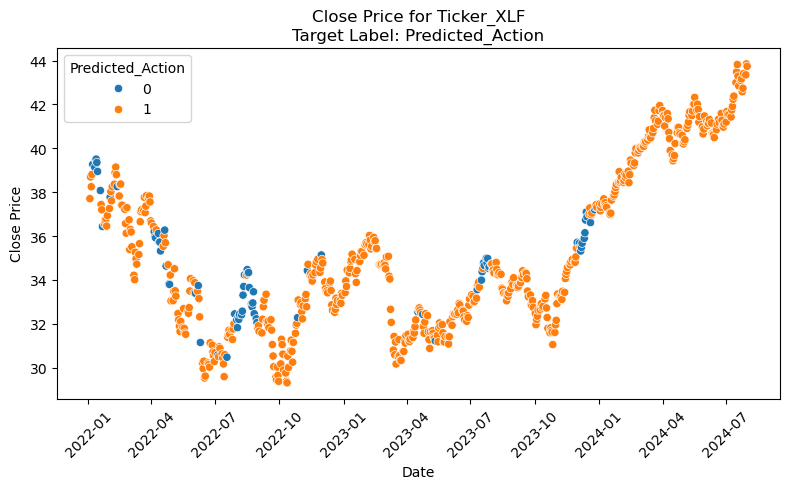

No data available for Ticker_XLF


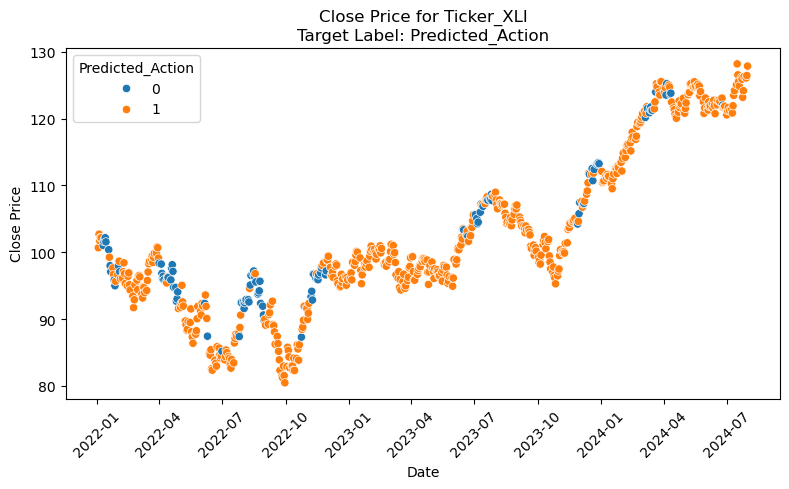

No data available for Ticker_XLI


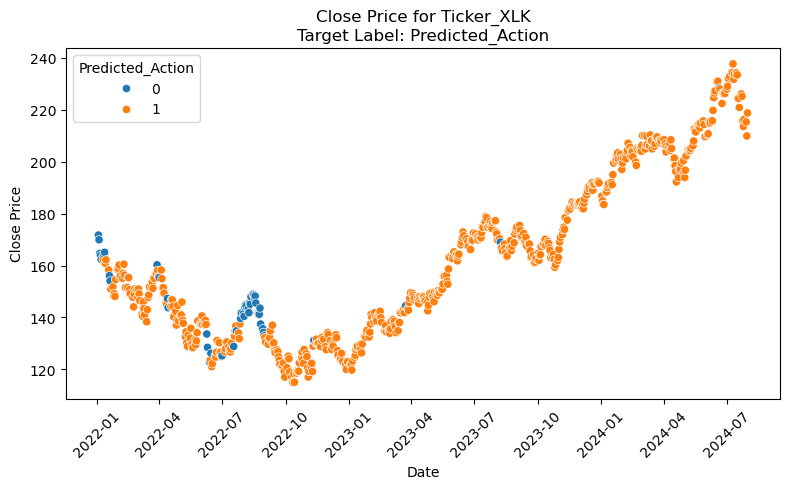

No data available for Ticker_XLK


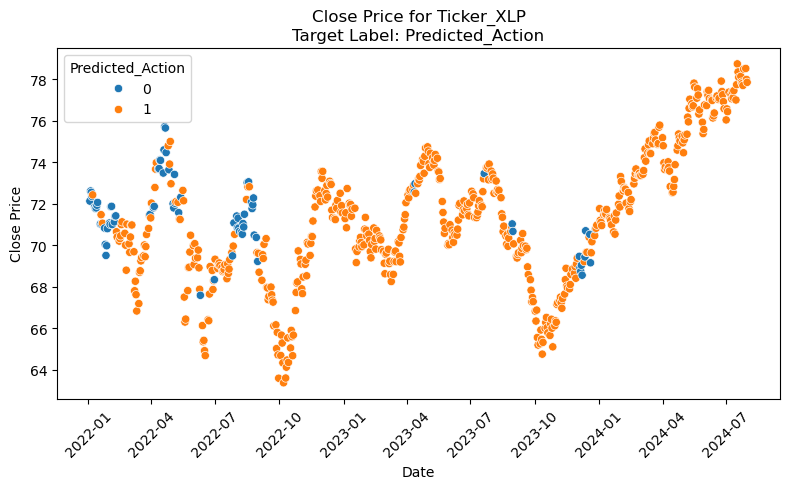

No data available for Ticker_XLP


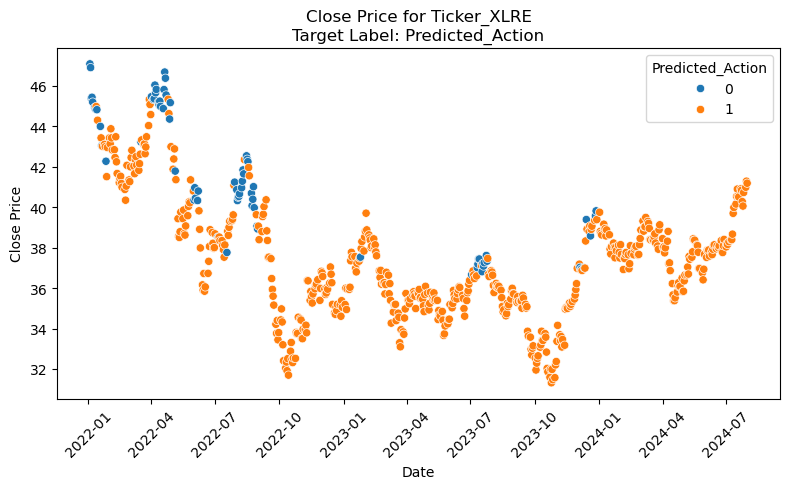

No data available for Ticker_XLRE


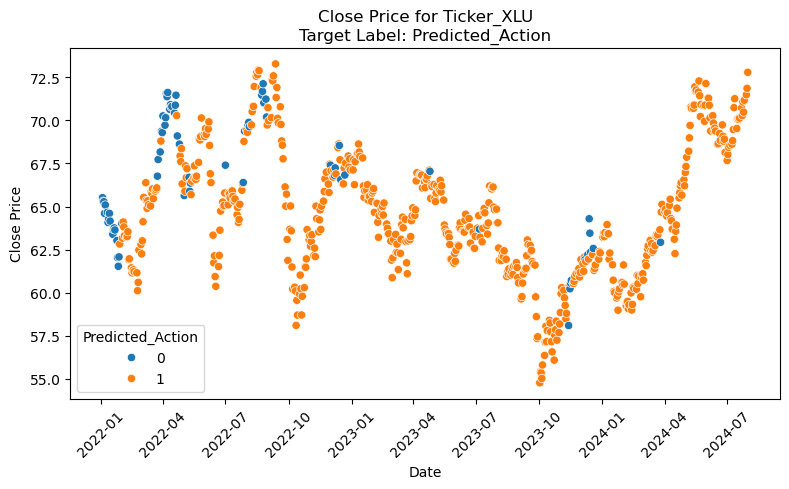

No data available for Ticker_XLU


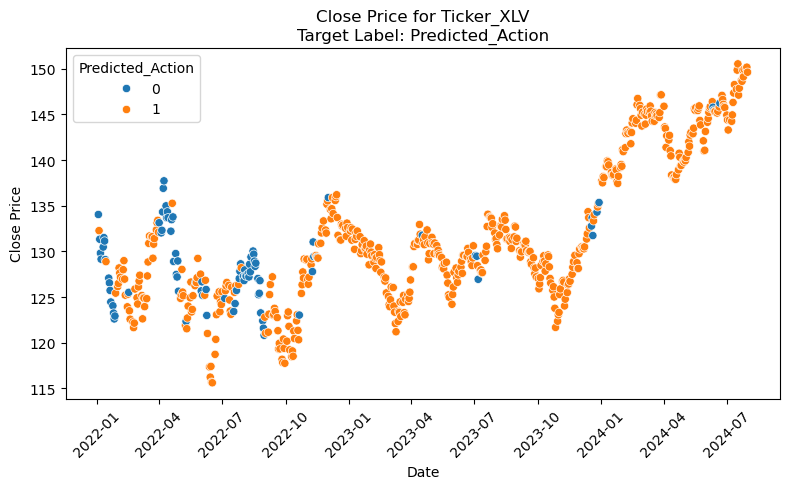

No data available for Ticker_XLV


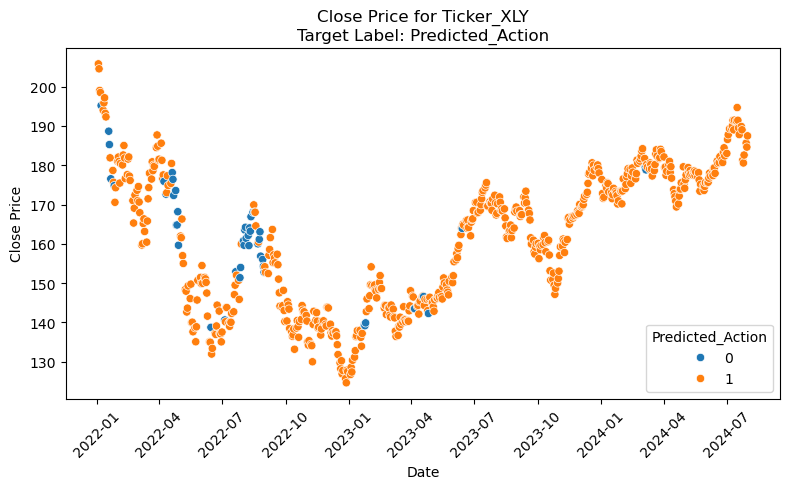

No data available for Ticker_XLY


In [1098]:
plot_hue_column2(data,column='Predicted_Action')

In [1292]:
test['Predicted_Action2']

24880     True
25051     True
24899     True
24956     True
24861    False
         ...  
35191     True
35323     True
35367     True
35169     True
35389     True
Name: Predicted_Action2, Length: 10412, dtype: bool

In [279]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
#joined=pd.get_dummies(joined,columns=['Ticker'])
# Assuming 'joined' is your DataFrame and it has a date column
# Ensure the DataFrame is sorted by date

# Create a mapping of your current labels to 0-based index
label_mapping = {label: idx for idx, label in enumerate(sorted(joined['Performance_Label'].unique()))}

# Apply this mapping to your target variable
joined['Performance_Label'] = joined['Performance_Label'].map(label_mapping)

# Get the number of unique classes
num_classes = len(label_mapping)

print(f"Label mapping: {label_mapping}")
print(f"Number of classes: {num_classes}")


features = [col for col in joined.columns if 'lag' in col] + ['Month']#+[col for col in joined if 'Ticker' in col]
joined['Performance_Label']=joined['Performance_Label'].astype(int)
joined.sort_values(by='Date', inplace=True)
joined=joined.dropna(subset=features)
# Define the split point (e.g., 70% for training)
split_point = int(len(joined) * 0.7)

X_train = train[features]
y_train = train['Performance_Label']
X_test = test[features]
y_test = test['Performance_Label']

# Split the data into training and testing sets
train = joined.iloc[:split_point]
test = joined.iloc[split_point:]
# Create the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=num_classes,
    random_state=42,
    
)
# Fit the model
xgb_clf.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
#print('Recall', recall_score(y_test,y_pred))
#print('F1_score', f1_score(y_test,y_pred))
print(classification_report(y_test, y_pred))


Label mapping: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
Number of classes: 6


/Users/johnprichard/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [14:53:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "average" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.019387657164795086
              precision    recall  f1-score   support

           0       0.00      0.17      0.00        12
           1       0.05      0.53      0.09       377
           2       0.00      0.00      0.00      5733
           3       0.00      0.00      0.00      4024
           4       0.00      0.00      0.00       262
           5       0.00      0.00      0.00        11

    accuracy                           0.02     10419
   macro avg       0.01      0.12      0.01     10419
weighted avg       0.00      0.02      0.00     10419



/Users/johnprichard/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnprichard/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/johnprichard/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [82]:
test['pred']=y_pred
# Assuming your dummy columns start with 'Ticker_'
ticker_columns = [col for col in test.columns if col.startswith('Ticker_')]

# Create a new 'Ticker' column
test['Ticker'] = test[ticker_columns].idxmax(axis=1).str.replace('Ticker_', '')

# Drop the dummy columns
test = test.drop(columns=ticker_columns)

#for ticker in sector_stocks.keys():
data=test[test['Year']>=2022]
plot_hue_column(data,column='pred')
#test[['Date','TTM_raw_lag7','TTM_pct_change_lag7','TTM_raw_lag8','TTM_pct_change_lag8','TTM','TTM_pct_change']].iloc[60:100]

ValueError: attempt to get argmax of an empty sequence

In [763]:
test[test['pred']==1]['Action'].value_counts()

Action
True     2383
False    1677
Name: count, dtype: int64

In [2]:
features

NameError: name 'features' is not defined

In [773]:
test[test['isDecreasing_lag1']==0]['Action'].value_counts()

Action
True     3622
False    2588
Name: count, dtype: int64

In [777]:
for c in joined.columns:
    print(c)

index
Date
Open
High
Low
Close
Volume
Dividends
Stock Splits
Capital Gains
Ticker
Is_Local_Max
Week
Year
Weekly_TTM
TTM
metric
donch
sma
MA
isDecreasing
Future_Close20
Future_Close19
Future_Close21
Action
Month
Future_pct_change
Performance_Label
Close_pct_change
Close_pct_change_lag1
Close_pct_change_lag2
Close_pct_change_lag3
Close_pct_change_lag4
Close_pct_change_lag5
Close_pct_change_lag6
Close_pct_change_lag7
Close_pct_change_lag8
Close_pct_change_lag9
Close_pct_change_lag10
Close_pct_change_lag11
Close_pct_change_lag12
Close_pct_change_lag13
Close_pct_change_lag14
Close_pct_change_lag15
Close_pct_change_lag16
Close_pct_change_lag17
Close_pct_change_lag18
Close_pct_change_lag19
Close_pct_change_lag20
TTM_Weekly_change
TTM_change_lag1
TTM_change_lag2
TTM_change_lag3
TTM_change_lag4
TTM_change_lag5
TTM_change
TTM_raw_lag1
TTM_raw_lag2
TTM_raw_lag3
TTM_raw_lag4
TTM_raw_lag5
TTM_change_lag6
TTM_raw_lag6
TTM_change_lag7
TTM_raw_lag7
TTM_change_lag8
TTM_raw_lag8
TTM_change_lag9
TTM_raw_

In [926]:
test[test['isDecreasing_lag1']==0]['Future_pct_change'].mean()

0.007130100570703986

In [928]:
test[test['pred']==1]['Future_pct_change'].mean()

0.013601095566206763

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_21618/2810090000.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'], utc=True).dt.tz_localize(None)


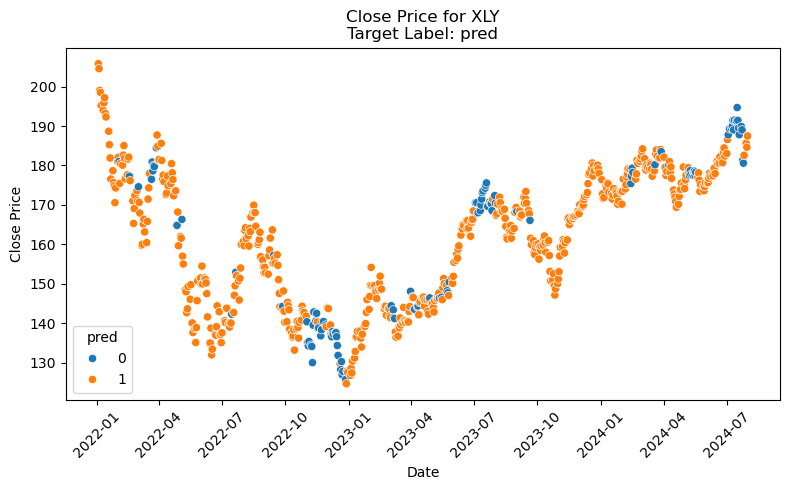

In [835]:
#for ticker in sector_stocks.keys():
data=test[test['Year']>=2022]
plot_hue_column(data,column='pred',plot_one=True)

In [837]:
data[data['pred']==1]['Close_pct_change'].mean()

0.015689657573058232

In [649]:
data[data['pred']!=1]['Close_pct_change'].mean()

0.08889095755776681

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
# Prepare X and y
X = joined[features]
y = joined['Target']